## Logistic Differential Equation
$$\frac{\partial f}{\partial t} = Rf(t)(1-f(t))$$

In [ ]:
! pip install torchopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.0/672.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 29.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from functorch import make_functional, grad, vmap, vjp, jacrev
import torchopt
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
##define the customized step function using torchopt's framework
##it does not retain or create the computational graph, using much less memory

from torchopt.update import apply_updates
from torchopt.typing import UninitializedState

def costum_step(
        optimizer,
        loss: torch.Tensor,
        params,
        inplace: bool | None = None,
    ):
        if isinstance(optimizer.optim_state, UninitializedState):
            optimizer.optim_state = optimizer.impl.init(params)

        if inplace is None:
            inplace = optimizer.inplace

        # Step parameter only
        grads = torch.autograd.grad(loss, params, create_graph=False, retain_graph=False, allow_unused=True)
        updates, optimizer.optim_state = optimizer.impl.update(
            grads,
            optimizer.optim_state,
            params=params,
            inplace=inplace,
        )
        return apply_updates(params, updates, inplace=inplace)

In [ ]:
class NNApproximator(nn.Module):
  def __init__(
      self,
      num_inputs = 1,
      num_outputs = 1,
      num_hidden = 1,
      dim_hidden = 1,
      act = nn.Tanh(),
  ):
    super().__init__()
    self.layer_in = nn.Linear(num_inputs, dim_hidden)
    self.layer_out = nn.Linear(dim_hidden, num_outputs)

    num_middle = num_hidden - 1
    self.middle_layers = nn.ModuleList(
        [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
    )
    self.act = act
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    out = self.act(self.layer_in(x))
    for layer in self.middle_layers:
      out = self.act(layer(out))
    return self.layer_out(out)

In [ ]:
##use functorch to make the above model functional
model = NNApproximator() ##build a model
fmodel, params = make_functional(model)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
params

(Parameter containing:
 tensor([[-0.5578]], requires_grad=True),
 Parameter containing:
 tensor([-0.3008], requires_grad=True),
 Parameter containing:
 tensor([[0.9111]], requires_grad=True),
 Parameter containing:
 tensor([-0.9035], requires_grad=True))

In [ ]:
##define the functional model of the NN
## x is the input to the NN and params is the NN's parameters
def f(x: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_).squeeze(0)
  return res

#use vmap primitive to allow efficient batching of the input
f_vmap = vmap(f, in_dims=(0, None))

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [ ]:
##define functions to compute the gradient of the NN w.r.t. the. input
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('grad')


In [ ]:
R = 1.0
X_BOUNDARY = 0.0 #x coordinate of the boundary
F_BOUNDARY = 0.5 #boundary value

##define the loss function
##params is the parameters of the NN, x is the colocation input to the NN
def loss_fn(params: torch.Tensor, x: torch.Tensor, alpha=1) -> torch.Tensor:
  #interior loss
  f_value = f_vmap(x, params)
  interior = dfdx(x, params) - R*f_value*(1-f_value)

  #boundary loss
  x0 = X_BOUNDARY
  f0 = F_BOUNDARY
  x_boundary = torch.tensor([x0])
  f_boundary = torch.tensor([f0])
  boundary = f_vmap(x_boundary, params) - f_boundary

  loss = nn.MSELoss()
  colocation_loss = loss(interior, torch.zeros_like(interior))
  BC_loss = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*colocation_loss + (2-alpha)*BC_loss
  return loss_value, colocation_loss, BC_loss

In [ ]:
#define optimization configuration
batch_size = 30 ##number of colocation points sampled in each iteration
num_iter = 100 #maximum number of iterations
learning_rate = 1e-1
domain = (-5.0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, display_every=10):
  loss_trace = []; colocation_trace = []; bc_trace = []
  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colo, loss_bc = loss_fn(params, x)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colo))
    bc_trace.append(float(loss_bc))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colo)}, BC: {loss_bc}")
  return params, loss_trace, colocation_trace, bc_trace


In [ ]:
new_param, loss_trace, colo_trace, bc_trace = train_model(num_iter, params, batch_size, domain)

Iteration 9 with loss 0.17644789814949036, colocation: 0.006570720579475164, BC: 0.16987717151641846
Iteration 19 with loss 0.09169937670230865, colocation: 0.08335047215223312, BC: 0.008348904550075531
Iteration 29 with loss 0.12010529637336731, colocation: 0.11582192778587341, BC: 0.0042833685874938965
Iteration 39 with loss 0.08283942192792892, colocation: 0.06945731490850449, BC: 0.013382106088101864
Iteration 49 with loss 0.07246711850166321, colocation: 0.06226235628128052, BC: 0.010204759426414967
Iteration 59 with loss 0.07421337813138962, colocation: 0.06812820583581924, BC: 0.006085173226892948
Iteration 69 with loss 0.07715342938899994, colocation: 0.07274048775434494, BC: 0.0044129411689937115
Iteration 79 with loss 0.07590577006340027, colocation: 0.07184174656867981, BC: 0.004064020700752735
Iteration 89 with loss 0.07361990213394165, colocation: 0.06970035284757614, BC: 0.003919545561075211
Iteration 99 with loss 0.07231196016073227, colocation: 0.06797684729099274, BC: 

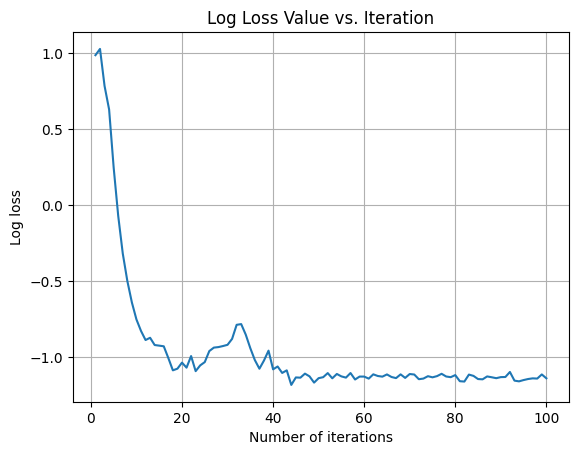

In [ ]:
##plot the loss value
plt.plot(range(1, num_iter+1), np.log10(loss_trace));
plt.xlabel("Number of iterations");
plt.ylabel("Log loss");
plt.title("Log Loss Value vs. Iteration");
plt.grid();

The analytical solution to the Logistic Equation is:

$$
f(t) = \frac{1}{Ke^{Rt} + 1}
$$

In [ ]:
def analytic_logistic(x, R, K):
  return 1/(K*np.exp(-R*x) + 1)

In [ ]:
##plot the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.1))
Y_NN = f_vmap(X_grid, params)
Y_analytic = analytic_logistic(X_grid, R, 1)
plt.plot(X_grid.detach().numpy(), Y_NN.detach().numpy(), label="Network Solution");
plt.plot(X_grid.detach().numpy(), Y_analytic.detach().numpy(), label="Analytic Solution");
plt.grid();
plt.legend();

NameError: ignored

Now, try to solve the following 1st order linear ODE system:

$$
\begin{cases}
  \dot{u_i} + A_i u_i = F_i \\
  u_i(0) = [x_i^{(0)}, 0]^T
\end{cases}
$$

### Network Structure
The network structure is a very simple fully connected one:

1-128-128-128-256-2

With Tanh as the activation function

In [ ]:
##this network has structure: 1 - 128 - 128 - 128 - 256 - 2
class SingleHeadNN(nn.Module):
  def __init__(self, act = nn.Tanh()):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 128)
    self.linear2 = nn.Linear(128, 128)
    self.linear3 = nn.Linear(128, 128)
    self.linear4 = nn.Linear(128, 256)
    self.linear5 = nn.Linear(256, 2)

  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out = self.linear5(out)
    return out

In [ ]:
singlehead = SingleHeadNN()
fmodel, params = make_functional(singlehead)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
def f_singlehead(x, params):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_).squeeze(0)
  return res

f_singlehead_vmap = vmap(f_singlehead, in_dims=(0, None), randomness="same")

##define gradient of the NN
dfdx_singlehead = vmap(jacrev(f_singlehead), in_dims=(0, None), randomness="same")

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


Let's use this forcing function to test:

$$
F(t) = \begin{bmatrix}
0 \\ \gamma cos(wt)
\end{bmatrix}
$$

The matrix A is of this form:

$$
A = \begin{bmatrix}
0 & -1 \\ \alpha & \delta
\end{bmatrix}
$$

The boundary condition is of this form:

$$
u(0) = \begin{bmatrix}
 x^{(0)} \\ 0
\end{bmatrix}
$$

In [ ]:
##define the parameters for the Duffing Equation
gamma = 1; w = 1; alpha = 1; delta = 2;
A = torch.FloatTensor([[0, -1], [alpha, delta]])
##boundary condition
X_BOUNDARY = 0.0
F_BOUNDARY = 0.5

##define a forcing function
def force(x):
  return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T

In [ ]:
##define the loss function
def loss_fn(params, x, A, alpha=1):
  #interior loss
  f_values = f_singlehead_vmap(x, params)
  f_gradients = dfdx_singlehead(x, params)
  Au = torch.einsum('ij,kj->ki', f_values, A).T
  forcing = force(x)
  interior = f_gradients + Au - forcing

  #boundary loss
  x_boundary = torch.tensor([X_BOUNDARY])
  f_boundary = torch.tensor([F_BOUNDARY, 0])
  boundary = f_singlehead_vmap(x_boundary, params) - f_boundary

  loss = nn.MSELoss()
  loss_colocation = loss(interior, torch.zeros_like(interior))
  loss_BC = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*loss_colocation + (2-alpha)*loss_BC

  return loss_value, loss_colocation, loss_BC

In [ ]:
#define optimization configuration
batch_size = 30 ##number of colocation points sampled in each iteration
num_iter = 1000 #maximum number of iterations
learning_rate = 1e-3
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, A, alpha=1, display_every=10):
  loss_trace = []; colocation_trace = []; BC_trace = []
  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colocation, loss_BC = loss_fn(params, x, A, alpha=alpha)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colocation))
    BC_trace.append(float(loss_BC))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colocation)}, BC: {loss_BC}")
  return params, loss_trace, colocation_trace, BC_trace

In [ ]:
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A, alpha=1.9, display_every=100)

Iteration 99 with loss 0.026563212275505066, colocation: 0.01289945188909769, BC: 0.020542539656162262
Iteration 199 with loss 0.01168846059590578, colocation: 0.006140428129583597, BC: 0.00021647567336913198
Iteration 299 with loss 0.005160870496183634, colocation: 0.002701838267967105, BC: 0.0002737755130510777
Iteration 399 with loss 0.0036595426499843597, colocation: 0.0019129483262076974, BC: 0.00024940905859693885
Iteration 499 with loss 0.00403476320207119, colocation: 0.0020953838247805834, BC: 0.0005353396409191191
Iteration 599 with loss 0.0024627577513456345, colocation: 0.001294276094995439, BC: 3.633146843640134e-05
Iteration 699 with loss 0.0022865277715027332, colocation: 0.0012016934342682362, BC: 3.31041264871601e-05
Iteration 799 with loss 0.0018725700210779905, colocation: 0.0009583774954080582, BC: 0.0005165278562344611
Iteration 899 with loss 0.002894503762945533, colocation: 0.0014957860112190247, BC: 0.000525103067047894
Iteration 999 with loss 0.0006780212861485

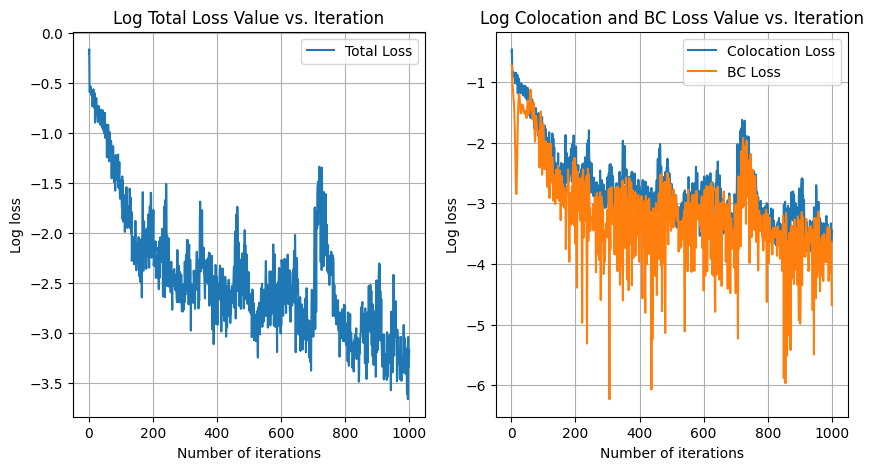

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f_singlehead_vmap(X_grid, new_params)

In [ ]:
#get the numerical solver solution
#define the RHS function
def func(t, y):
   y = np.array(y)
   A_mat = np.array([[0, -1], [alpha, delta]])
   return -A_mat@y + np.array([0, gamma*np.cos(w*t)])

numerical_result = solve_ivp(func, domain, np.array([F_BOUNDARY, 0]),
                             t_eval=np.arange(domain[0], domain[1], 0.05))

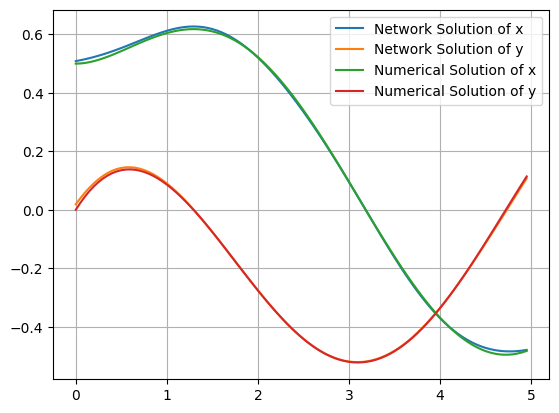

In [ ]:
##Plot the network solution
plt.plot(X_grid, Y_NN[:,0].detach().numpy(), label="Network Solution of x");
plt.plot(X_grid, Y_NN[:,1].detach().numpy(), label="Network Solution of y");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[0], label="Numerical Solution of x");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[1], label="Numerical Solution of y");
plt.legend();
plt.grid();

### New Network Structure

This new network structure will fit the one-shot TL:

1-256-256-256-512-(2, 256)-2

The first 4 hidden layers are fully connected. The 512 dimensional output is reshaped into H of shape (2, 256). Finally a linear layer of zero bias is applied to both components of H.

We will first try the single head approach to see it this network also works.

In [ ]:
class NNApproximator2(nn.Module):
  def __init__(self, act = nn.Tanh()):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, 256)
    self.linear4 = nn.Linear(256, 512)
    self.final_linear = nn.Linear(256, 1, bias=False)

  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out1 = out[:256]
    out2 = out[256:]
    out1 = self.final_linear(out1)
    out2 = self.final_linear(out2)
    return torch.cat((out1, out2))

In [ ]:
##construct a model
model = NNApproximator2()
fmodel, params = make_functional(model)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
##make the model fully functional and define the jacobian function
def f2(x, params):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_).squeeze(0)
  return res

f2_vmap = vmap(f2, in_dims=(0, None), randomness="same")

##define gradient of the NN
df2dx = vmap(jacrev(f2), in_dims=(0, None), randomness="same")

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


In [ ]:
##define the parameters for the Duffing Equation
gamma = 1; w = 1; alpha = 1; delta = 2;
A = torch.FloatTensor([[0, -1], [alpha, delta]])
##boundary condition
X_BOUNDARY = 0.0
F_BOUNDARY = 0.5

##define a forcing function
def force(x):
  return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T

In [ ]:
##define the loss function
def loss_fn(params, x, A, alpha=1):
  #interior loss
  f_values = f2_vmap(x, params)
  f_gradients = df2dx(x, params)
  Au = torch.einsum('ij,kj->ki', f_values, A).T
  forcing = force(x)
  interior = f_gradients + Au - forcing

  #boundary loss
  x_boundary = torch.tensor([X_BOUNDARY])
  f_boundary = torch.tensor([F_BOUNDARY, 0])
  boundary = f2_vmap(x_boundary, params) - f_boundary

  loss = nn.MSELoss()
  loss_colocation = loss(interior, torch.zeros_like(interior))
  loss_BC = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*loss_colocation + (2-alpha)*loss_BC

  return loss_value, loss_colocation, loss_BC

In [ ]:
#define optimization configuration
batch_size = 30 ##number of colocation points sampled in each iteration
num_iter = 1000 #maximum number of iterations
learning_rate = 1e-3
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, A, alpha=1, display_every=10):
  loss_trace = []; colocation_trace = []; BC_trace = []
  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colocation, loss_BC = loss_fn(params, x, A, alpha=alpha)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colocation))
    BC_trace.append(float(loss_BC))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colocation)}, BC: {loss_BC}")
  return params, loss_trace, colocation_trace, BC_trace

In [ ]:
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A, alpha=1.9, display_every=100)

Iteration 99 with loss 0.0585656464099884, colocation: 0.03017466515302658, BC: 0.012337814085185528
Iteration 199 with loss 0.005895745009183884, colocation: 0.00295252981595695, BC: 0.002859382191672921
Iteration 299 with loss 0.005586274899542332, colocation: 0.00282282498665154, BC: 0.0022290763445198536
Iteration 399 with loss 0.0007253040093928576, colocation: 0.0003172169963363558, BC: 0.001225917600095272
Iteration 499 with loss 0.0005946132587268949, colocation: 0.00023776100715622306, BC: 0.0014286733930930495
Iteration 599 with loss 0.0013874733122065663, colocation: 0.0006692081806249917, BC: 0.0011597786797210574
Iteration 699 with loss 0.0036869067698717117, colocation: 0.0017988082254305482, BC: 0.002691709902137518
Iteration 799 with loss 0.0004359707818366587, colocation: 0.00021481139992829412, BC: 0.00027829137980006635
Iteration 899 with loss 0.0012301248498260975, colocation: 0.000632445327937603, BC: 0.00028478848980739713
Iteration 999 with loss 0.000440129311755

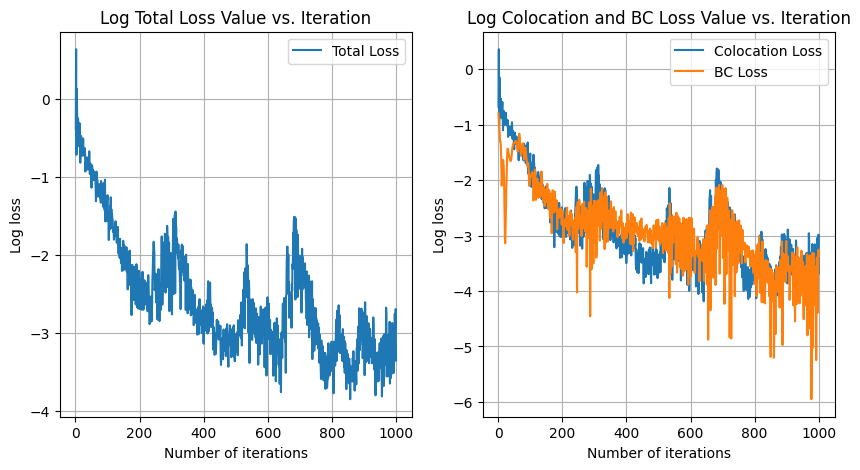

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f2_vmap(X_grid, new_params)

In [ ]:
#get the numerical solver solution
#define the RHS function
def func(t, y):
   y = np.array(y)
   A_mat = np.array([[0, -1], [alpha, delta]])
   return -A_mat@y + np.array([0, gamma*np.cos(w*t)])

numerical_result = solve_ivp(func, domain, np.array([F_BOUNDARY, 0]),
                             t_eval=np.arange(domain[0], domain[1], 0.05))

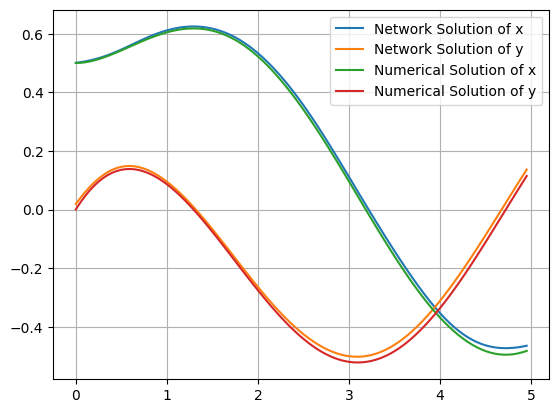

In [ ]:
##Plot the network solution
plt.plot(X_grid, Y_NN[:,0].detach().numpy(), label="Network Solution of x");
plt.plot(X_grid, Y_NN[:,1].detach().numpy(), label="Network Solution of y");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[0], label="Numerical Solution of x");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[1], label="Numerical Solution of y");
plt.legend();
plt.grid();

The new structure looks good, it is actually better then the previous one.


## Real Implementation
### Multiheaded Structure
Let's try to implement the multiheaded version of the above network structure.

2-256-256-256-512-(2, 257) - k heads of shape 2.

The matrix H of shape (2, 257) includes one bias column.

$H \in (2 by 257)$



In [ ]:
class Multihead(nn.Module):
  def __init__(self, k, act = nn.Tanh()):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, 256)
    self.linear4 = nn.Linear(256, 512)
    ##define k final layers without bias
    self.final_layers = nn.ModuleList(
        ##use 257 if include the bias
        [nn.Linear(256, 1, bias=False) for _ in range(k)]
    )
    self.k = k

  #it returns the output of the network and the hidden state
  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out1 = out[:256]
    #out1 = torch.cat((torch.Tensor([1]), out1))
    out2 = out[256:]
    #out2 = torch.cat((torch.Tensor([1]), out2))
    output = []
    for i in range(self.k):
      first = self.final_layers[i](out1)
      second = self.final_layers[i](out2)
      concat = torch.cat((first, second))
      output.append(concat)
    return torch.stack(output), out

In [ ]:
##construct a model of 10 heads
k=10
model = Multihead(k=k)
fmodel, params = make_functional(model)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
model

Multihead(
  (act): Tanh()
  (linear1): Linear(in_features=1, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-9): 10 x Linear(in_features=256, out_features=1, bias=False)
  )
)

In [ ]:
##make the model fully functional and define the jacobian function
##this function only returns the output of the network
def f_multihead(x, params):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_)[0].squeeze(0)
  return res

#if input x contains B elements
##the output of this function will be a tensor of shape (B, k, 2)
##where k is the number of heads
f_multihead_vmap = vmap(f_multihead, in_dims=(0, None), randomness="same")

##define gradient of the NN
dfdx_multihead = vmap(jacrev(f_multihead), in_dims=(0, None), randomness="same")

##this function returns the hidden state of the network
##the hidden state depends on: 1. time 2. parameters of the network
def hidden_state(x, params):
  x_ = x.unsqueeze(0)
  H = fmodel(params, x_)[1].squeeze(0)
  return H

##returns the batched hidden states of shape (B, 512)
hidden_state_vmap = vmap(hidden_state, in_dims=(0, None), randomness="same")

#define gradient of the hidden state H'
#returns the batched gradients of the hidden states of shape (B, 512)
dHdx = vmap(jacrev(hidden_state), in_dims=(0, None), randomness="same")

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


In [ ]:
gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
alpha_bounds = (0.5, 4.5)
delta_bounds = (0.5, 4.5)
boundary_bounds = (-3, 3)

##this function generates k sets of parameters
##it returns a numpy array of shape (k, 4)
##and another numpy array of shape(k,) <- boundary values
def generate_parameters(k, gb = gamma_bounds,
                        wb = w_bounds, ab = alpha_bounds, db = delta_bounds,
                        bounds=boundary_bounds, seed=10):
  parameters = np.zeros((k, 4))
  boundaries = np.zeros(k)
  ##set the random seed
  np.random.seed(seed)
  for i in range(k):
    parameters[i] = [np.random.uniform(gb[0], gb[1]),
                     np.random.uniform(wb[0], wb[1]),
                     np.random.uniform(ab[0], ab[1]),
                     np.random.uniform(db[0], db[1])]
    boundaries[i] = np.random.uniform(bounds[0], bounds[1])
  return parameters, boundaries

In [ ]:
##generate the parameter set
parameter_set, F_BOUNDARIES = generate_parameters(k)

In [ ]:
##decorator to return a forcing function of form gamma*cos(w*t)
def force_decorator(gamma, w):
  def force(x):
    return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T
  return force

##construct a list forcing function from the parameter set
forcing_functions = [force_decorator(p[0], p[1]) for p in parameter_set]
##construct a tensor that stores k matrice A (10, 2, 2) from the parameter set
A_matrices = torch.zeros(k, 2, 2)
for i in range(k):
  A_matrices[i] = torch.Tensor([[0.0, -1.0], [parameter_set[i][2], parameter_set[i][3]]])

##boundary condition
X_BOUNDARY = 0.0

In [ ]:
##define the loss function
def loss_fn(params, x, A_matrices, forcing_functions, alpha=1, X_BOUNDARY=0.0):
  #interior loss
  f_values = f_multihead_vmap(x, params) ##of shape (30, 10, 2)
  f_gradients = dfdx_multihead(x, params) ##of shape (30, 10, 2)
  # Expand dimensions of 'A_matrices' to match the shape of 'f_values'
  expanded_A_matrices = A_matrices.unsqueeze(0).expand(f_values.shape[0], -1, -1, -1)
  # Perform element-wise matrix multiplication using broadcasting
  Au = torch.matmul(expanded_A_matrices, f_values.unsqueeze(-1)).squeeze(-1)
  del expanded_A_matrices

  forcing = torch.stack([f(x) for f in forcing_functions]).transpose(1, 0) #shape (30, 10, 2)
  interior = f_gradients + Au - forcing #of shape (30, 10, 2)
  del f_gradients, Au, forcing

  x_boundary = torch.tensor([X_BOUNDARY])
  f_boundary = torch.stack([torch.Tensor([b, 0]) for b in F_BOUNDARIES])
  boundary = f_multihead_vmap(x_boundary, params) - f_boundary ##of shape (1, 10, 2)

  loss = nn.MSELoss()
  loss_colocation = loss(interior, torch.zeros_like(interior))
  loss_BC = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*loss_colocation + (2-alpha)*loss_BC

  return loss_value, loss_colocation, loss_BC

In [ ]:
#define optimization configuration
batch_size = 100 ##number of colocation points sampled in each iteration
num_iter = 3000 #maximum number of iterations
learning_rate = 3e-4
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, A_matrices, forcing_functions,
                optimizer, alpha=1, display_every=10):
  loss_trace = []; colocation_trace = []; BC_trace = []

  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colocation, loss_BC = loss_fn(params, x, A_matrices, forcing_functions, alpha=alpha)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colocation))
    BC_trace.append(float(loss_BC))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colocation)}, BC: {float(loss_BC)}")

    del loss, loss_colocation, loss_BC
  return params, loss_trace, colocation_trace, BC_trace

In [ ]:
%time
Alpha=1
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A_matrices, forcing_functions,
                                    optimizer, alpha=Alpha, display_every=100)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Iteration 99 with loss 0.6119725108146667, colocation: 0.5716963410377502, BC: 0.040276143699884415
Iteration 199 with loss 0.3369961380958557, colocation: 0.3344428837299347, BC: 0.0025532657746225595
Iteration 299 with loss 0.27449777722358704, colocation: 0.27302876114845276, BC: 0.001469014910981059
Iteration 399 with loss 0.1275329291820526, colocation: 0.12702681124210358, BC: 0.0005061171250417829
Iteration 499 with loss 0.05662912130355835, colocation: 0.05597279965877533, BC: 0.0006563224596902728
Iteration 599 with loss 0.021934673190116882, colocation: 0.021867286413908005, BC: 6.73862814437598e-05
Iteration 699 with loss 0.00636929739266634, colocation: 0.006348832044750452, BC: 2.0465497073018923e-05
Iteration 799 with loss 0.004605854861438274, colocation: 0.004533306695520878, BC: 7.254837692016736e-05
Iteration 899 with loss 0.003735329257324338, colocation: 0.003714611055329442, BC: 2.071809649351053e-05
It

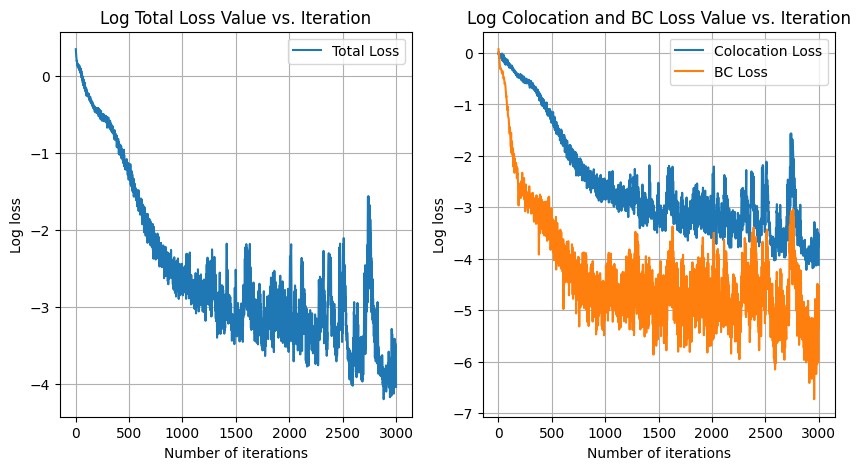

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f_multihead_vmap(X_grid, new_params) #shape (100, 10, 2)
Y_NN = Y_NN.transpose(0, 1)

In [ ]:
##get numerical solutions
#define the RHS function decorator
def RHS_decorator(gamma, w, alpha, delta):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + np.array([0, gamma*np.cos(w*t)])
  return func

t_eval = np.arange(domain[0], domain[1], 0.05)
##construct a list of RHS functions
RHS_functions = [RHS_decorator(p[0], p[1], p[2], p[3]) for p in parameter_set]

numerical_result = [solve_ivp(RHS_functions[i], domain,
                    np.array([F_BOUNDARIES[i], 0]), t_eval=t_eval) for i in range(k)]

### Plot the Network Solution together with the Numerical Solution

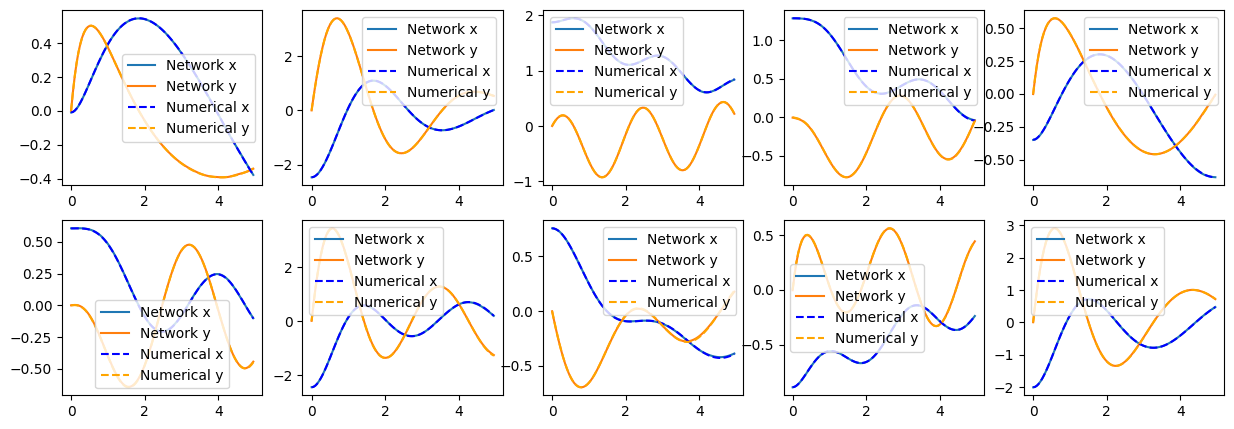

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5));
for i in range(10):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, Y_NN[i][:,0].detach().numpy(), label="Network x");
  ax[j][l].plot(X_grid, Y_NN[i][:,1].detach().numpy(), label='Network y');
  ax[j][l].plot(t_eval, numerical_result[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(t_eval, numerical_result[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].legend();

## One-Shot Transfer Learning

In [ ]:
##this function returns the matrix M
##x is the batch of time (Tensor)
##params is the parameters of the neural network
##alpha is the parameter used in the ODE
##Alpha is the weight used in the loss function
def M_matrix(x, alpha, delta, params, Alpha=1):
  ##compute the batched Hidden states
  Hs = hidden_state_vmap(x, params).detach().numpy() #(B, 512)
  ##compute the batched gradients of the hidden states
  H_primes = dHdx(x, params).detach().numpy() #(B, 512)
  ##construct the matrix A
  A = np.array([[0.0, -1.0], [alpha, delta]])

  #compute the first part of the matrix M
  results = []
  for i in range(Hs.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    hp = H_primes[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    B = hp.T@A@h
    matrix = hp.T@hp + B + B.T + h.T@A.T@A@h
    results.append(matrix)
  results = np.array(results)
  results = np.mean(results, axis=0)

  #compute the second part of the matrix M
  #compute the hidden state at time 0
  h0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #h0 = np.hstack((np.ones((h0.shape[0], 1)), h0)) ##add the bias column
  return Alpha*results + (2-Alpha)*h0.T@h0

#compute the analytic W that minimizes the loss function
#alpha is the parameter used in the ODE
#Alpha is the weight used in the loss functioon
def compute_W(x, alpha, delta, params, Minv, F, boundary_value, Alpha=1):
  h0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #h0 = np.hstack((np.ones((h0.shape[0], 1)), h0)) ##add the bias column
  u0 = np.array([[boundary_value], [0]]) ##boundary condition

  ##compute the batched Hidden states
  Hs = hidden_state_vmap(x, params).detach().numpy()
  ##compute the batched gradients of the hidden states
  H_primes = dHdx(x, params).detach().numpy()
  ##construct the matrix A
  A = np.array([[0.0, -1.0], [alpha, delta]])

  fs = F(x) #(B, 2) shape
  if type(fs) is not np.ndarray:
    fs = fs.numpy()
  results = []
  for i in range(Hs.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    hp = H_primes[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    f = fs[i].reshape(2, 1)
    results.append((hp.T + h.T@A.T)@f)
  results = np.array(results)
  results = Alpha*np.mean(results, axis=0) + (2-Alpha)*h0.T@u0
  W = Minv@results
  return W

Try out the following unseen parameters:
$$
\alpha = 1, \delta = 0.5, \gamma = 1, w = 2
$$

Boundary at 0.5.

In [ ]:
##get the true numerical solution
#define the RHS function
def RHS_decorator(gamma, w, alpha, delta):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + np.array([0, gamma*np.cos(w*t)])
  return func

#this function gives you the solution of an unseen ODE using one-shot transfer learning
#x: tensor: batched tensors of inputs to compute the M and W
#a, d, r, omega, boundary are all parameters of the ODE
#params: is the trained network's parameters
#X_grid: the values at which we want to evaluate the network at
#returns:
#a numpy nd array of (N, 2) where N is the size of X_grid
def one_shot_TL(x, a, d, r, omega, boundary, params, X_grid, alpha=1, F = None):
  ##decorator to return a forcing function of form gamma*cos(w*t)
  def force_decorator(gamma, w):
    def force(x):
      return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T
    return force
  M = M_matrix(x, a, d, params, Alpha=alpha); Minv = np.linalg.inv(M)
  #define forcing function
  if F is None:
    F = force_decorator(r, omega)
  ##compute the analytic W
  W = compute_W(x, a, d, params, Minv, F, boundary, Alpha=alpha)
  Hs = hidden_state_vmap(X_grid, params).detach().numpy()
  analytic_result = []
  for i in range(X_grid.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    analytic_result.append(h@W)
  analytic_result = np.array(analytic_result)
  return analytic_result, W

##this function computes the numerical solution on X_grid values
def compute_numerical_solution(a, d, r, omega, boundary, X_grid, domain):
  numerical_solution = solve_ivp(RHS_decorator(r, omega, a, d), domain, np.array([boundary, 0]),
                             t_eval=X_grid)
  return numerical_solution

In [ ]:
##get the network solution for this parameter set
a = 1; d = 0.5; r = 1; omega = 2; boundary = 0.5; Alpha=1
x = torch.FloatTensor(100).uniform_(domain[0], domain[1])
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
analytic_result, W = one_shot_TL(x, a, d, r, omega, boundary, new_params, X_grid, alpha=Alpha)
##get the numerical solution
numerical_solution = compute_numerical_solution(a, d, r, omega, boundary, X_grid, domain)

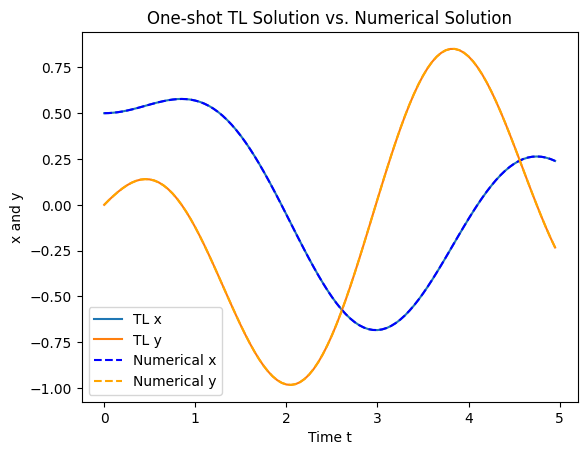

In [ ]:
plt.plot(X_grid, analytic_result[:,0], label='TL x');
plt.plot(X_grid, analytic_result[:,1], label='TL y')
plt.plot(X_grid, numerical_solution.y[0], '--', c='blue', label="Numerical x");
plt.plot(X_grid, numerical_solution.y[1], '--', c='orange', label="Numerical y");
plt.legend();
plt.xlabel("Time t");
plt.ylabel("x and y");
plt.title("One-shot TL Solution vs. Numerical Solution");

Now we need to find a way to quantatively measure the transfer-learning results. We will define the previous loss function for the TL learnt network.

In [ ]:
##this function computes the loss of the PINN after one-shot TL
def loss_TL(x, params, a, d, r, omega, W, boundary, alpha=1, F = None):
  H_prime = dHdx(x, params).detach().numpy() #B by 512
  H = hidden_state_vmap(x, params).detach().numpy() #B by 512
  A = np.array([[0.0, -1.0], [a, d]])
  if F is None:
    F = force_decorator(r, omega)
  fs = F(x)
  if type(fs) is not np.ndarray:
    fs = F(x).numpy()
  #colocation loss
  colo = []
  for i in range(H.shape[0]):
    hp = H_prime[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    h = H[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    colo.append((hp+A@h)@W - fs[i].reshape(2, 1))
  colo = np.array(colo)
  loss_colocation = (colo**2).sum()/H.shape[0]
  ##BC loss
  H0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #H0 = np.hstack((np.ones((H0.shape[0], 1)), H0)) ##add the bias column
  u0 = H0@W
  loss_BC = ((u0 - np.array([[boundary], [0]]))**2).sum()
  return alpha*loss_colocation + (2-alpha)*loss_BC, loss_colocation, loss_BC

In [ ]:
Alpha = 1
total_loss, loss_colo, loss_BC = loss_TL(x, new_params, a, d, r, omega, W, boundary, alpha=Alpha)
print("Using alpha = {}, the loss statistics of the previous parameter set is:".format(Alpha))
print("Weighted Total Loss: {}".format(total_loss))
print("Colocation Loss: {}".format(loss_colo))
print("BC loss: {}".format(loss_BC))

Using alpha = 1, the loss statistics of the previous parameter set is:
Weighted Total Loss: 2.7914492236174444e-07
Colocation Loss: 2.791449057853185e-07
BC loss: 1.6576425953179736e-14


### Try another 10 in-distribution parameter sets

In [ ]:
##generate the parameter set
k = 10
new_parameters, NEW_BOUNDARIES = generate_parameters(k, seed=108)

In [ ]:
new_solutions_TL = []
new_solutions_numerical = []
TL_Losses = [];
for i in range(k):
  a, d, r, omega = new_parameters[i]
  analytic, W = one_shot_TL(x, a, d, r, omega, NEW_BOUNDARIES[i], new_params, X_grid)
  numerical = compute_numerical_solution(a, d, r, omega, NEW_BOUNDARIES[i], X_grid, domain)
  TL_Losses.append(loss_TL(x, new_params, a, d, r, omega, W, NEW_BOUNDARIES[i], alpha=Alpha))
  new_solutions_TL.append(analytic)
  new_solutions_numerical.append(numerical)

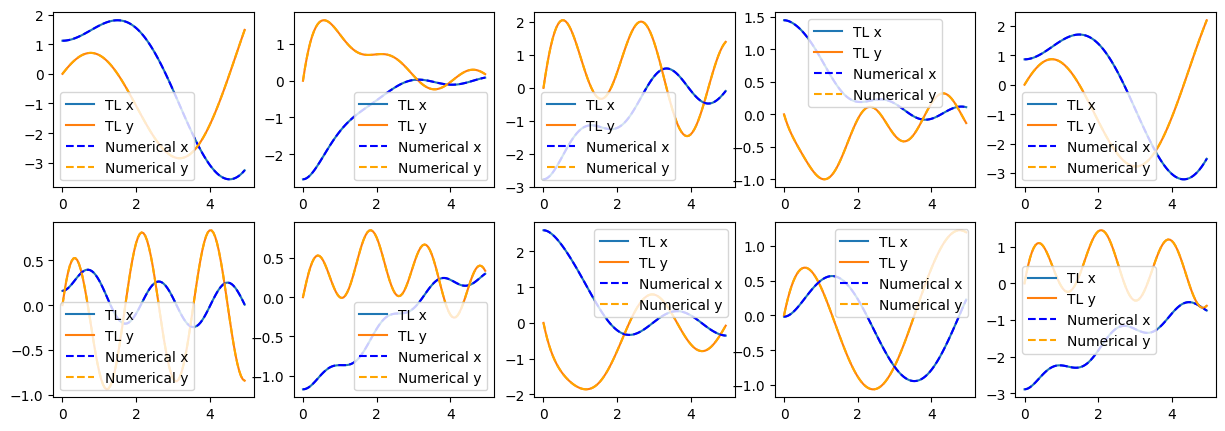

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5));
for i in range(10):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, new_solutions_TL[i][:,0], label="TL x");
  ax[j][l].plot(X_grid, new_solutions_TL[i][:,1], label='TL y');
  ax[j][l].plot(X_grid, new_solutions_numerical[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(X_grid, new_solutions_numerical[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].legend();

In [ ]:
print("Using alpha={}, below is the loss statistics for all 10 new parameters:".format(Alpha))
for i in range(10):
  print("Parameter set #{}".format(i+1))
  print("Total Loss: {}".format(TL_Losses[i][0]))
  print("Colocation Loss: {}".format(TL_Losses[i][1]))
  print("BC Loss: {}".format(TL_Losses[i][2]))
  print("===================================")

Using alpha=1, below is the loss statistics for all 10 new parameters:
Parameter set #1
Total Loss: 6.741779089206253e-06
Colocation Loss: 6.741778844188195e-06
BC Loss: 2.450180578677125e-13
Parameter set #2
Total Loss: 1.6079455202991143e-06
Colocation Loss: 1.6079430661156086e-06
BC Loss: 2.4541835056961995e-12
Parameter set #3
Total Loss: 4.154638447702851e-06
Colocation Loss: 4.15463804720799e-06
BC Loss: 4.00494861104943e-13
Parameter set #4
Total Loss: 4.759994339868479e-07
Colocation Loss: 4.759994168908152e-07
BC Loss: 1.7096032674566495e-14
Parameter set #5
Total Loss: 6.4138305206488205e-06
Colocation Loss: 6.413830302374211e-06
BC Loss: 2.1827460985142576e-13
Parameter set #6
Total Loss: 3.05333038492321e-06
Colocation Loss: 3.05333037751748e-06
BC Loss: 7.40573029510786e-15
Parameter set #7
Total Loss: 2.5711671764754963e-06
Colocation Loss: 2.5711671278598896e-06
BC Loss: 4.861560687113194e-14
Parameter set #8
Total Loss: 4.784960239535805e-06
Colocation Loss: 4.784958552

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##save the parameters
import pickle
file = open('/content/drive/MyDrive/PINN/PINN_program/new_params_10heads.obj', 'wb')
pickle.dump(new_params, file)
file.close()

In [ ]:
##reload the parameters if necessary
import pickle
file = open('/content/drive/MyDrive/PINN/PINN_program/new_params_10heads.obj', 'rb')
new_params = pickle.load(file)

## Try to Solve the Following Duffing Equation
$$
\frac{\partial^2 x}{\partial t^2} + 1.5 \frac{\partial x}{\partial t} + x + 0.5 x^3 = 0.5cos(2t)
$$

with $x_0 = 1$ and $x_0' = 0$

In [ ]:
delta = 1.5; alpha = 1; beta = 0.5; gamma = 0.5; omega = 2
domain = (0, 5.0); X_BOUNDARY = 1;

In [ ]:
##this function solves a Duffing Equation numerically
##f is a 1-1 function w.r.t. t
def solve_duffing(delta, alpha, beta, f, u0, domain, t_eval):
  def F(t, y):
    return [y[1],
            -delta*y[1]- alpha*y[0] - beta*y[0]**3 + f(t)]
  solution = solve_ivp(F, domain, u0, t_eval=t_eval)
  return solution

solution = solve_duffing(delta, alpha, beta, lambda t: gamma*np.cos(omega*t), [X_BOUNDARY, 0], domain, X_grid)

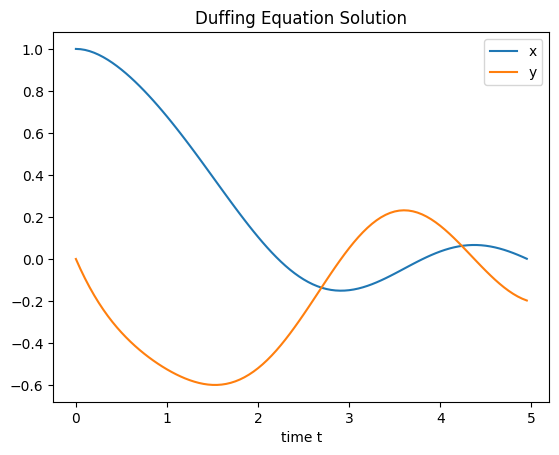

In [ ]:
##plot the numerical solution
plt.plot(solution.t, solution.y[0], label='x');
plt.plot(solution.t, solution.y[1], label='y');
plt.xlabel("time t");
plt.title("Duffing Equation Solution");
plt.legend();

### How to set the initial values of the p system?

First idea is to make the initial values the same across all systems.

then we have:

$$x_0  = \frac{x^{(0)}}{\sum_{i=0}^p \beta^{i}}$$

In [ ]:
##this function computes the uniform initial condition value for all p systems
def compute_initial(x0, beta, p):
  denominator = 0
  for i in range(p+1):
    denominator += beta**i
  return x0/denominator

def x0_function_decorator(W, params):
  def x0_function(x):
    return hidden_state_vmap(x, params).detach().numpy()[:, :256]@W
  return x0_function

def xi_function_decorator(W):
  def xi_function(x):
     return hidden_state_vmap(x, new_params).detach().numpy()[:, :256]@W
  return xi_function

def final_function_decorator(function_list, beta):
  def final_function(x):
    result = 0
    for i in range(len(function_list)):
      result += (beta**i)*function_list[i](x)
    return result
  return final_function

In [ ]:
##this function uses one-shot TL technique to solve the nonlinear duffing equation (the x0' is set to 0)
##Parameters:
## x0: the initial value of the duffing equation
## beta: parameter beta in the duffing equation
## p: number of linear systems to solve to approximate the Duffing Equation
## domain: the range at which the Duffing equation will be solved
## N: number of data points used to compute the result
def solve_duffing_TL(x0, beta, p, domain, N, alpha, delta, params, gamma, omega, Alpha=1, verbose=True):
  x0_initials = compute_initial(x0, beta, p)
  if verbose:
    print("Using uniform initial values of: {}".format(x0_initials))
  x = torch.linspace(domain[0] + (domain[1]-domain[0])/N, domain[1], N)
  ##solve the first linear ODE system
  ##compute the matrix M; this M only need to be computed and inverted once
  M = M_matrix(x, alpha, delta, params, Alpha=Alpha); Minv = np.linalg.inv(M)
  ##define the initial forcing function
  def force_decorator(gamma, w):
      def force(x):
        return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T
      return force
  F = force_decorator(gamma, omega)
  ##compute the analytic W
  W = compute_W(x, alpha, delta, params, Minv, F, x0_initials, Alpha=Alpha)
  x0_function = x0_function_decorator(W, params)
  W_list = [W]; function_list = [x0_function]
  ##solve the rest p linear ode system
  for i in range(1, p+1):
    if verbose:
      print("Solving the {}th linear ode system...".format(i))
    ##obtain the forcing function
    def force_function(x):
      result = 0
      for j1 in range(p+1):
        for j2 in range(p+1):
          for j3 in range(p+1):
            if j1+j2+j3 == i-1:
              result -= function_list[j1](x)*function_list[j2](x)*function_list[j3](x) #elementwise multiplication
      return np.hstack((np.zeros((result.shape[0], 1)), result))
    ##compute the analytic W
    W = compute_W(x, alpha, delta, params, Minv, force_function, x0_initials, Alpha=Alpha)
    ##obtain the function xi
    function_list.append(xi_function_decorator(W))
    W_list.append(W)
  final_function = final_function_decorator(function_list, beta)
  return final_function, function_list, W_list

#### Try to use the function to solve the Duffing Equation
and let's plot all solved solutions of p iterative linear ODE systems.

In [ ]:
p = 15
final_function, function_list, W_list = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200,
                                  alpha, delta, new_params, gamma, omega)

Using uniform initial values of: 0.5000076295109483
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...
Solving the 5th linear ode system...
Solving the 6th linear ode system...
Solving the 7th linear ode system...
Solving the 8th linear ode system...
Solving the 9th linear ode system...
Solving the 10th linear ode system...
Solving the 11th linear ode system...
Solving the 12th linear ode system...
Solving the 13th linear ode system...
Solving the 14th linear ode system...
Solving the 15th linear ode system...


Plot all p+1 linear system solutions. The final solution will be the linear combination of these functions

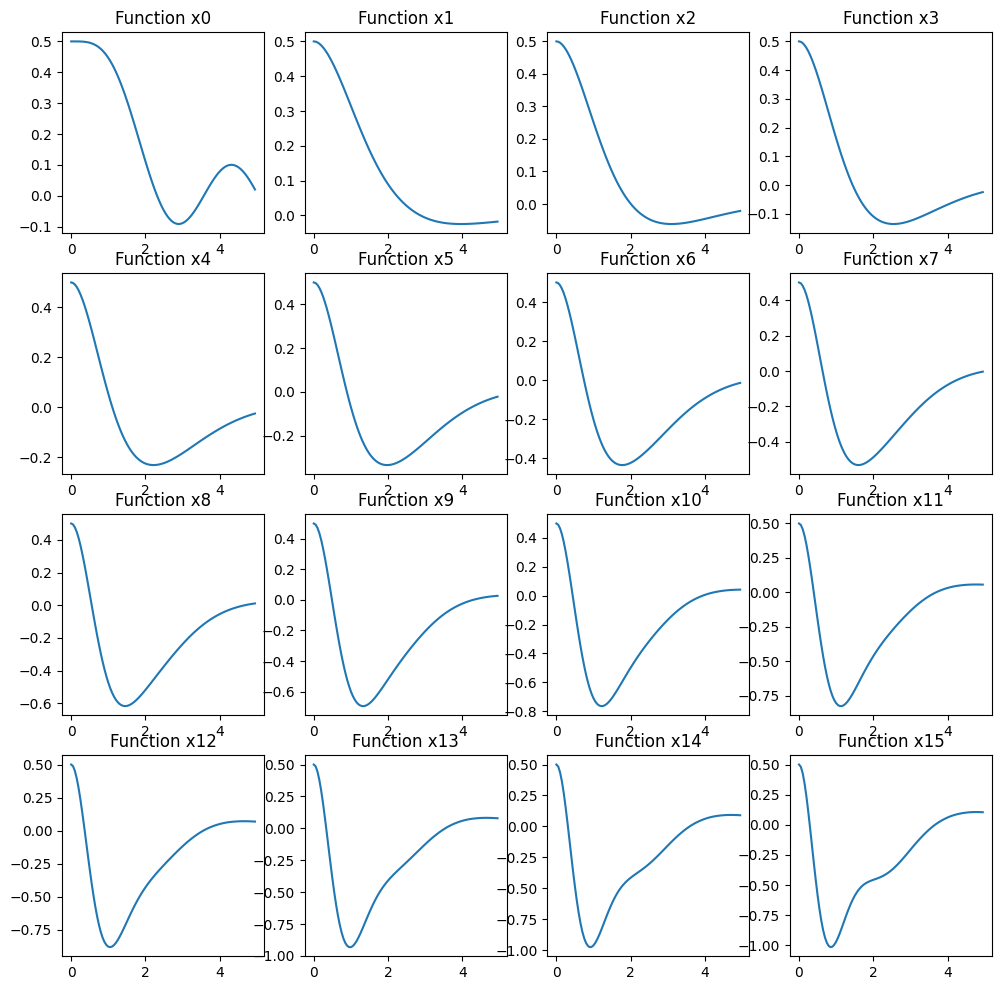

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(len(function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, function_list[i](X_grid))
  ax[j][k].set_title("Function x{}".format(i))

Plot the final combined solution and compare it with the numerical solution. We can see that using p=15, the one-shot TL solution matches the numerical solution exactly.

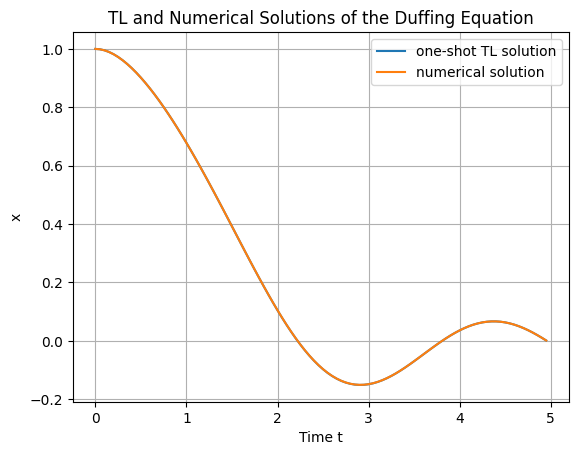

In [ ]:
plt.plot(X_grid, final_function(X_grid), label='one-shot TL solution');
plt.plot(solution.t, solution.y[0], label='numerical solution');
plt.grid();
plt.xlabel("Time t");
plt.ylabel("x");
plt.title("TL and Numerical Solutions of the Duffing Equation");
plt.legend();

Use different values of p to test how the method performs with different p values.

In [ ]:
P = 15
Final_List = []; Function_List_list = []; weights_list = []
for p in range(2, P+1):
  print("p = {}".format(p))
  ff, fl, w = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200,
                                  alpha, delta, new_params, gamma, omega)
  Final_List.append(ff)
  Function_List_list.append(fl)
  weights_list.append(w)
  print()

p = 2
Using uniform initial values of: 0.5714285714285714
Solving the 1th linear ode system...
Solving the 2th linear ode system...

p = 3
Using uniform initial values of: 0.5333333333333333
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...

p = 4
Using uniform initial values of: 0.5161290322580645
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...

p = 5
Using uniform initial values of: 0.5079365079365079
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...
Solving the 5th linear ode system...

p = 6
Using uniform initial values of: 0.5039370078740157
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...
Solving the 5th linear ode system...
Sol

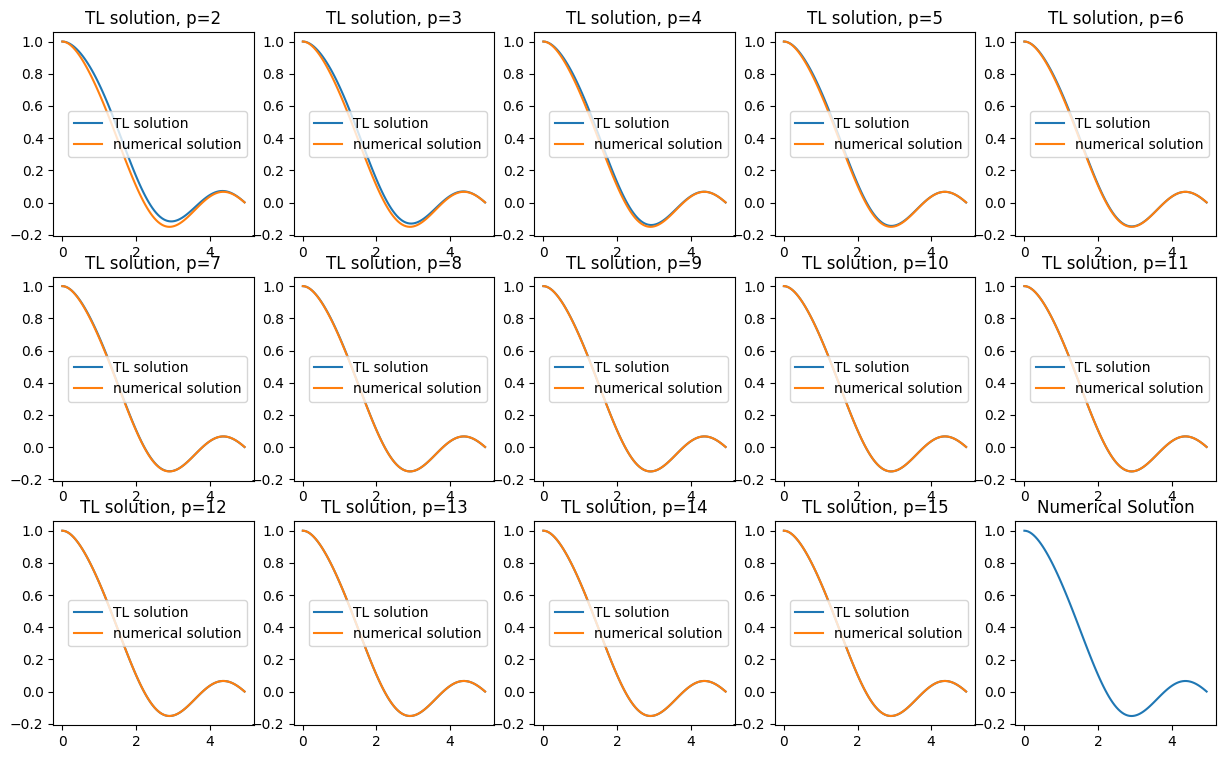

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 9))
for i in range(len(Final_List)):
  j = i//5; k = i%5
  ax[j][k].plot(X_grid, Final_List[i](X_grid).flatten(), label='TL solution')
  ax[j][k].plot(solution.t, solution.y[0], label='numerical solution')
  ax[j][k].legend();
  ax[j][k].set_title("TL solution, p={}".format(i+2))
ax[2][4].plot(solution.t, solution.y[0]);
ax[2][4].set_title("Numerical Solution");

We need a more quantitative measure of how different values of p perform. So we decide to compute the loss of each solution.

It is very hard to compute the ODE loss of the solution because the solution is a function of a linear combination of many neural network. Computing the second order derivative would be very hard.

It is also impossible to obtain the absolute analytic solution of the duffing equation. Therefore, we decide to use the MSE between the TL solution and the numerical solution as a measure to quantify how good the solution is.

In [ ]:
##this function computes the MSE between the TL solution and the numerical solution
##f is the function of solution handler
##solution is the numerical solution
def MSE_loss(f, solution):
  TL_solution = f(torch.Tensor(solution.t)).flatten()
  return ((TL_solution - solution.y[0])**2).mean()

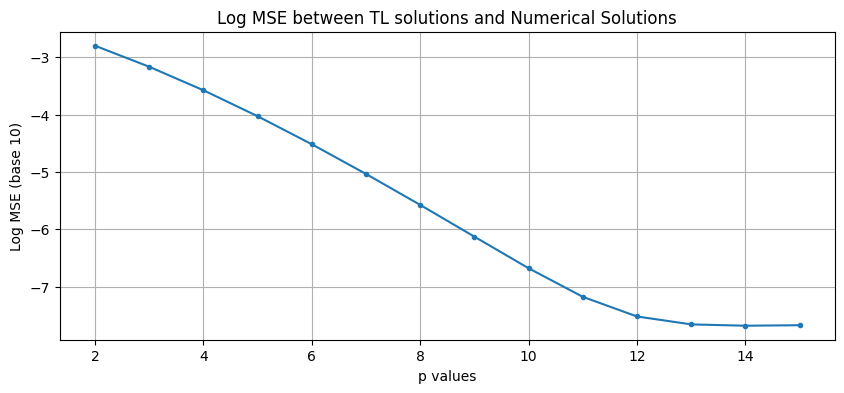

In [ ]:
##compute the MSE loss for all p values and plot them
mse_losts = []
for f in Final_List:
  mse_losts.append(MSE_loss(f, solution))

plt.figure(figsize=(10, 4));
plt.plot(range(2, len(Final_List)+2), np.log10(mse_losts), '.-');
plt.grid();
plt.title("Log MSE between TL solutions and Numerical Solutions");
plt.xlabel("p values");
plt.ylabel("Log MSE (base 10)");

#### See How well Each of p Linear System is solved

In [ ]:
##this function computes the iterative forcing function in the ith linear ODE numerically
##using the computed function list by one-shot TL
def iterative_force_decorator(function_list, p, i):
  def force_function(x):
    result = 0
    for j1 in range(p+1):
      for j2 in range(p+1):
        for j3 in range(p+1):
          if j1+j2+j3 == i-1:
            result -= function_list[j1](x)*function_list[j2](x)*function_list[j3](x) #elementwise multiplication
    return np.hstack((np.zeros((result.shape[0], 1)), result))
  return force_function

##compute the iterative. forcing function for i from 1 to 15
iterative_forcing_list = [iterative_force_decorator(Function_List_list[-1], 15, i) for i in range(1, 16)]

Let's how each of the p forcing functions in the p linear systems look like.

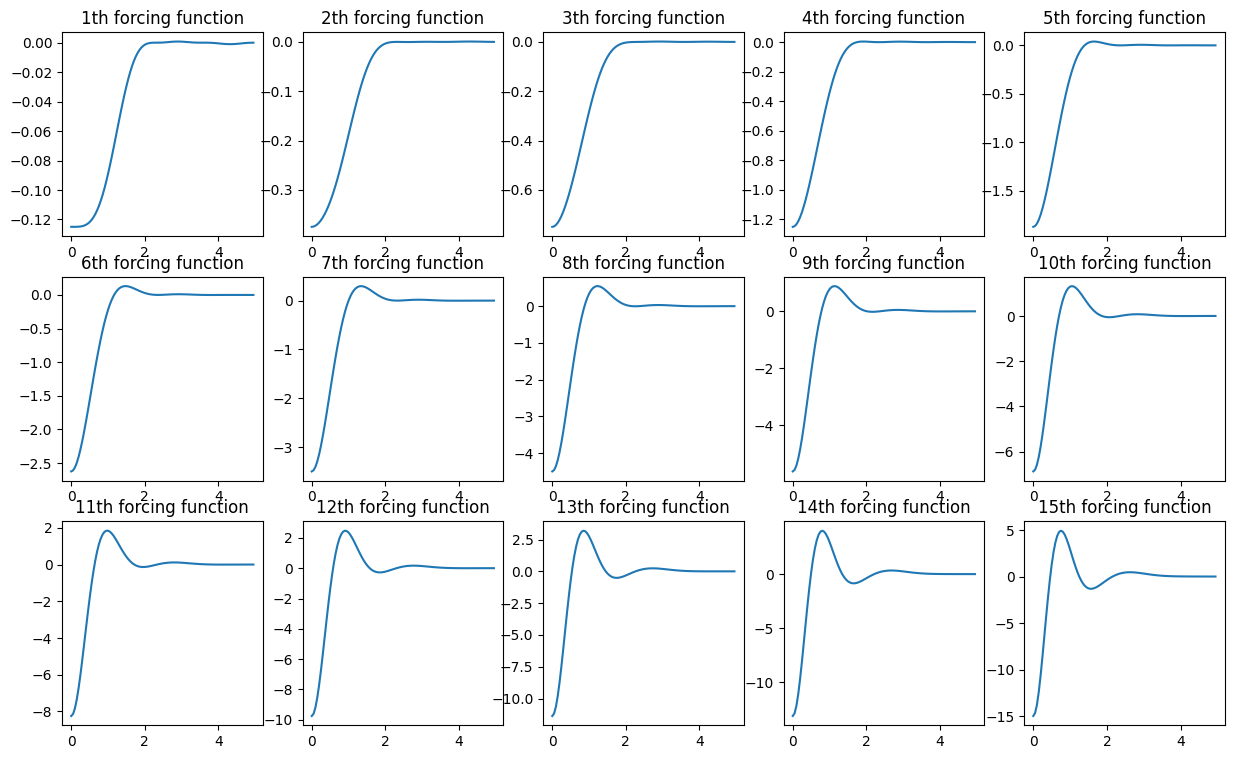

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 9));
for i in range(len(iterative_forcing_list)):
  j = i//5; k = i%5
  ax[j][k].plot(X_grid, iterative_forcing_list[i](X_grid)[:,1])
  ax[j][k].set_title("{}th forcing function".format(i+1))

Let's compute and plot the TL loss of the p linear systems.

In [ ]:
## compute the loss of the p TL solutions
x = torch.linspace(domain[0] + (domain[1]-domain[0])/200, domain[1], 200)
boundary = compute_initial(X_BOUNDARY, beta, 15)
total_loss = []; colo_loss = []; BC_loss = []
for i in range(len(weights_list[-1])):
  if i == 0:
    F = None
  else:
    F = iterative_forcing_list[i-1]
  tl, cl, bl = loss_TL(x, new_params, alpha, delta,
            gamma, omega, weights_list[-1][i], boundary=boundary, F=F)
  total_loss.append(tl);
  colo_loss.append(cl);
  BC_loss.append(bl);

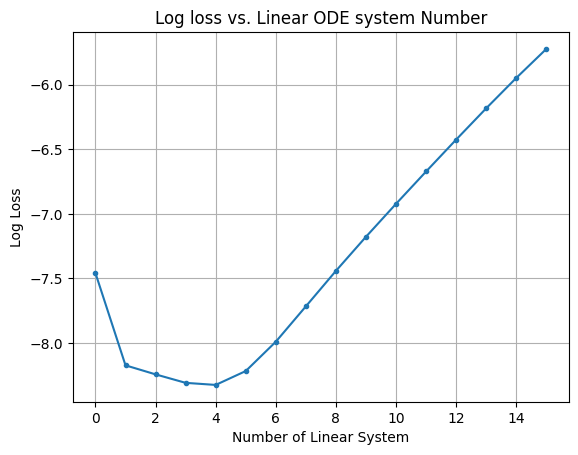

In [ ]:
plt.plot(range(16), np.log10(total_loss), '.-');
plt.grid();
plt.xlabel("Number of Linear System");
plt.ylabel("Log Loss");
plt.title("Log loss vs. Linear ODE system Number");

In [ ]:

Solution_list = []
iterative_forcing_list[0](torch.Tensor([1]))
for i in range(len(iterative_forcing_list)):
  print(i)
  #construct the forcing function
  def Fi(t):
    return iterative_forcing_list[i](torch.Tensor([t]))[0]
  def RHS_func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + Fi(t)
  ##solve the system numerically
  solution = solve_ivp(RHS_func, domain, np.array([compute_initial(X_BOUNDARY, beta, len(iterative_forcing_list)), 0]),
                       t_eval=X_grid)
  Solution_list.append(solution)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


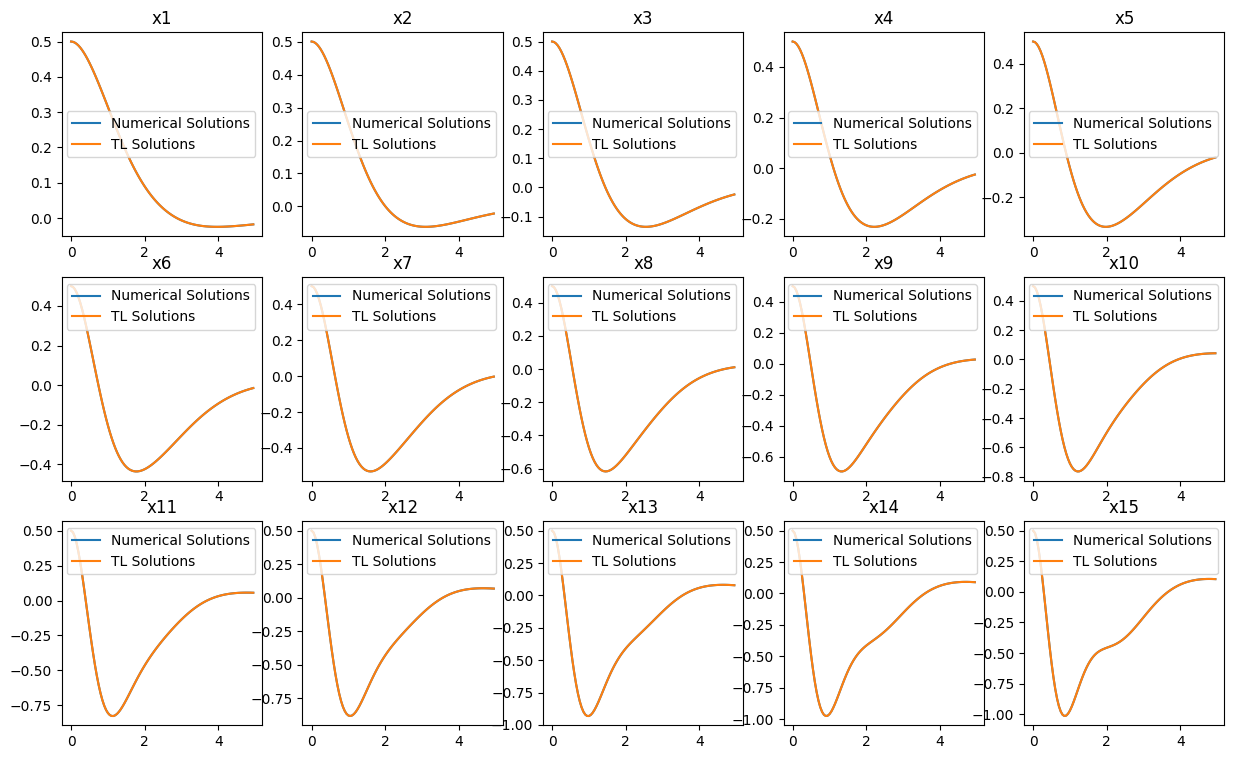

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 9));
for i in range(15):
  j = i//5; k = i%5
  ax[j][k].plot(X_grid, Solution_list[i].y[0], label="Numerical Solutions")
  ax[j][k].plot(X_grid, Function_List_list[-1][i+1](X_grid).flatten(), label="TL Solutions")
  ax[j][k].set_title("x{}".format(i+1))
  ax[j][k].legend();

#### Try out different parameters of the Duffing Equation and see how the TL solver performs

Try out in-distribution parameters first. Fix $\beta$ to 0.5 first.

In [ ]:
##generate 20 random set of new parameters for Duffing equation

gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
alpha_bounds = (0.5, 4.5)
delta_bounds = (0.5, 4.5)
boundary_bounds = (-3, 3)

Duffing_parameters = generate_parameters(20, gb = gamma_bounds,
                        wb = w_bounds, ab = alpha_bounds, db = delta_bounds,
                        bounds=boundary_bounds, seed=1)

In [ ]:
##solve these 20 Duffing equations numerically and using TL
nume_duff_solution = []
TL_duff_functions = []
TL_duff_solution = []
for i in range(20):
  print(i)
  delta = Duffing_parameters[0][i][3]
  alpha = Duffing_parameters[0][i][2]
  bd = Duffing_parameters[1][i]
  gamma = Duffing_parameters[0][i][0]
  omega = Duffing_parameters[0][i][1]
  #numerical solutions
  solu = solve_duffing(delta, alpha, 0.5,
                       lambda t: gamma*np.cos(omega*t),
                        [bd, 0], domain, X_grid)
  nume_duff_solution.append(solu)
  #TL solutions
  p=12
  ff, _, _ = solve_duffing_TL(bd, 0.5, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_duff_functions.append(ff)
  TL_duff_solution.append(ff(X_grid.flatten()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


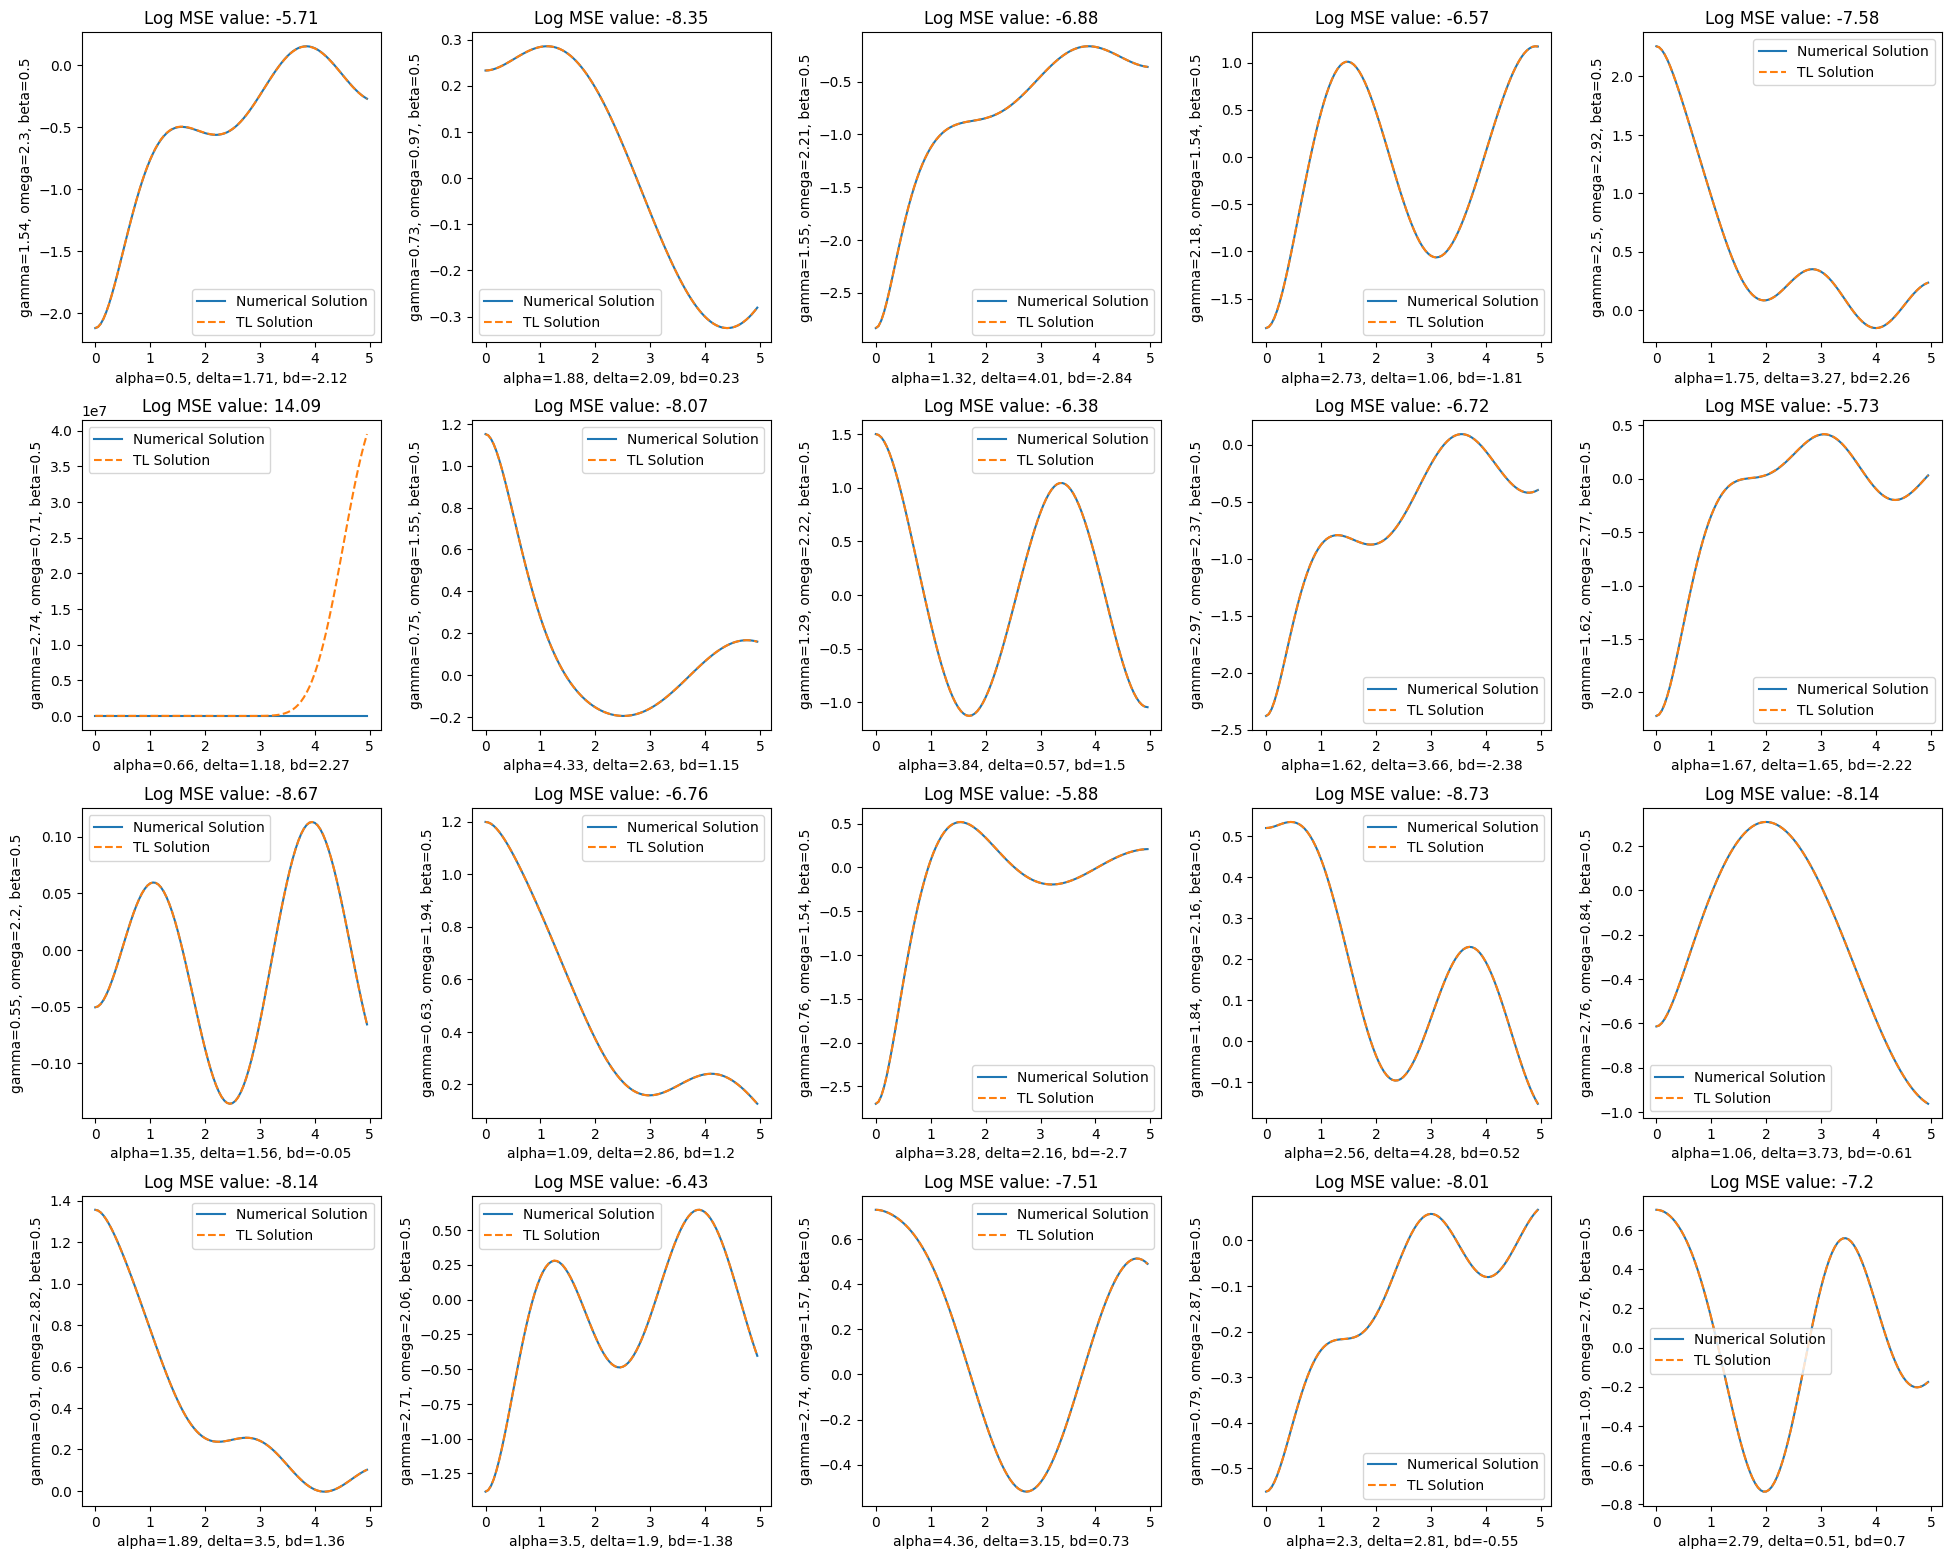

In [ ]:
##plot the solutions
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(nume_duff_solution[i].t, nume_duff_solution[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_duff_solution[i], '--', label='TL Solution')
  ##compute the MSE loss value
  loss = MSE_loss(TL_duff_functions[i], nume_duff_solution[i])
  ax[j][k].legend();
  ax[j][k].set_title("Log MSE value: " + str(round(np.log10(loss), 2)))
  ax[j][k].set_xlabel("alpha={}, delta={}, bd={}".format(round(Duffing_parameters[0][i][2], 2),
                                                 round(Duffing_parameters[0][i][3], 2),
                                                 round(Duffing_parameters[1][i], 2)))
  ax[j][k].set_ylabel("gamma={}, omega={}, beta={}".format(
      round(Duffing_parameters[0][i][0], 2),
      round(Duffing_parameters[0][i][1], 2),
      0.5
  ))

Setting one in-distribution parameters set and let $\beta$ vary and see how the solver performs.

In [ ]:
##use the original parameters set except for beta
delta = 1.5; alpha = 1; gamma = 0.5; omega = 2
domain = (0, 5.0); X_BOUNDARY = 1;
##define the range of beta we want to vary
Beta = np.arange(0.1, 2.1, 0.1)

In [ ]:
numerical_solutions = []; TL_functions = []; TL_solutions = []
for beta in Beta:
  print("beta: {}".format(beta))
  ##compute the numerical solutions
  solu = solve_duffing(delta, alpha, beta,
                       lambda t: gamma*np.cos(omega*t),
                        [X_BOUNDARY, 0], domain, X_grid)
  numerical_solutions.append(solu)
  ##compute the TL solutions
  p = 12
  ff, _, _ = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_functions.append(ff)
  TL_solutions.append(ff(X_grid.flatten()))

beta: 0.1
beta: 0.2
beta: 0.30000000000000004
beta: 0.4
beta: 0.5
beta: 0.6
beta: 0.7000000000000001
beta: 0.8
beta: 0.9
beta: 1.0
beta: 1.1
beta: 1.2000000000000002
beta: 1.3000000000000003
beta: 1.4000000000000001
beta: 1.5000000000000002
beta: 1.6
beta: 1.7000000000000002
beta: 1.8000000000000003
beta: 1.9000000000000001
beta: 2.0


In [ ]:
##compute the MSE loss for all betas
MSE_beta = []
for i, f in enumerate(TL_functions):
  MSE_beta.append(MSE_loss(f, numerical_solutions[i]))

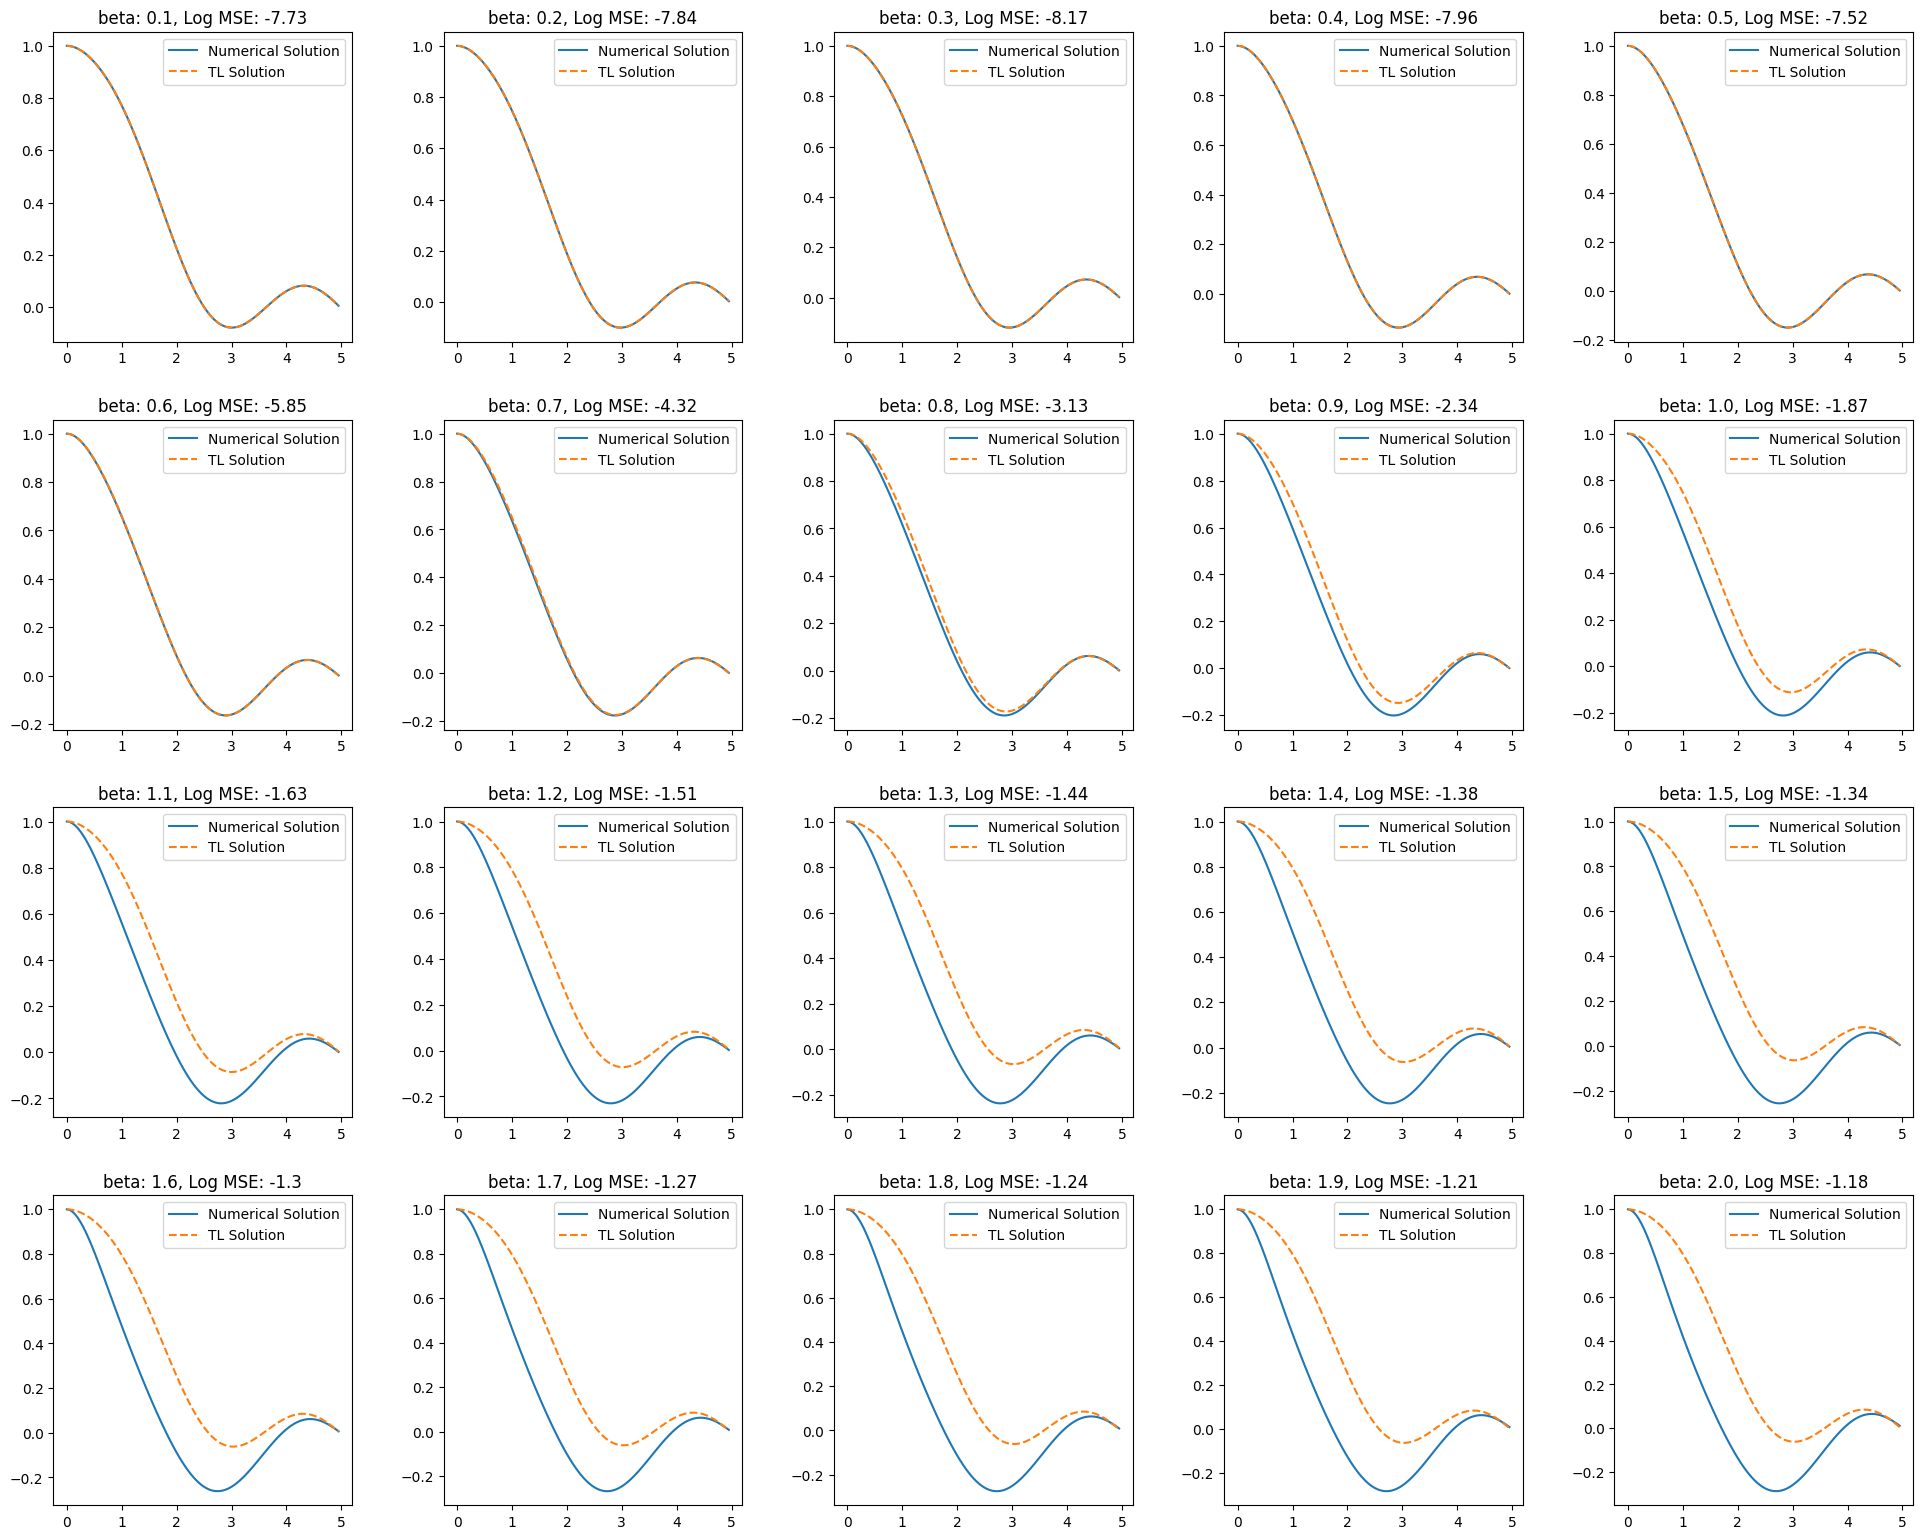

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(numerical_solutions[i].t, numerical_solutions[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_solutions[i], '--', label="TL Solution")
  ax[j][k].legend()
  ax[j][k].set_title("beta: {}, Log MSE: {}".format(round(Beta[i], 1), round(np.log10(MSE_beta[i]), 2)))

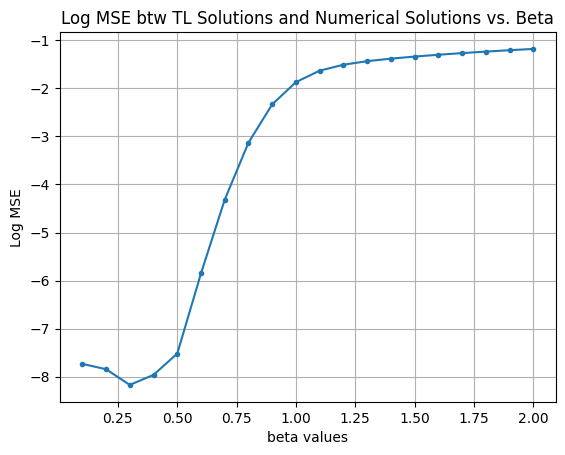

In [ ]:
plt.plot(Beta, np.log10(MSE_beta), '.-');
plt.grid();
plt.xlabel("beta values");
plt.ylabel("Log MSE");
plt.title("Log MSE btw TL Solutions and Numerical Solutions vs. Beta");

### Test how the solver performs in stiff vs non-stiff regions
Fix all parameters except for $\delta$, test how the solver performs when $\delta$ varies.

In [ ]:
##use the original parameters set except for delta
beta = 0.5; alpha = 1; gamma = 0.5; omega = 2
domain = (0, 5.0); X_BOUNDARY = 1;
##define the range of delta we want to vary
Delta = np.arange(0.1, 10.5, 0.5)

In [ ]:
numerical_delta = []; TL_functions_delta = []; TL_solutions_delta = []
for delta in Delta:
  print("delta: {}".format(delta))
  ##compute the numerical solutions
  solu = solve_duffing(delta, alpha, beta,
                       lambda t: gamma*np.cos(omega*t),
                        [X_BOUNDARY, 0], domain, X_grid)
  numerical_delta.append(solu)
  ##compute the TL solutions
  p = 12
  ff, _, _ = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_functions_delta.append(ff)
  TL_solutions_delta.append(ff(X_grid.flatten()))

delta: 0.1
delta: 0.6
delta: 1.1
delta: 1.6
delta: 2.1
delta: 2.6
delta: 3.1
delta: 3.6
delta: 4.1
delta: 4.6
delta: 5.1
delta: 5.6
delta: 6.1
delta: 6.6
delta: 7.1
delta: 7.6
delta: 8.1
delta: 8.6
delta: 9.1
delta: 9.6
delta: 10.1


In [ ]:
##compute the MSE loss for all deltas
MSE_delta = []
for i, f in enumerate(TL_functions_delta):
  MSE_delta.append(MSE_loss(f, numerical_delta[i]))

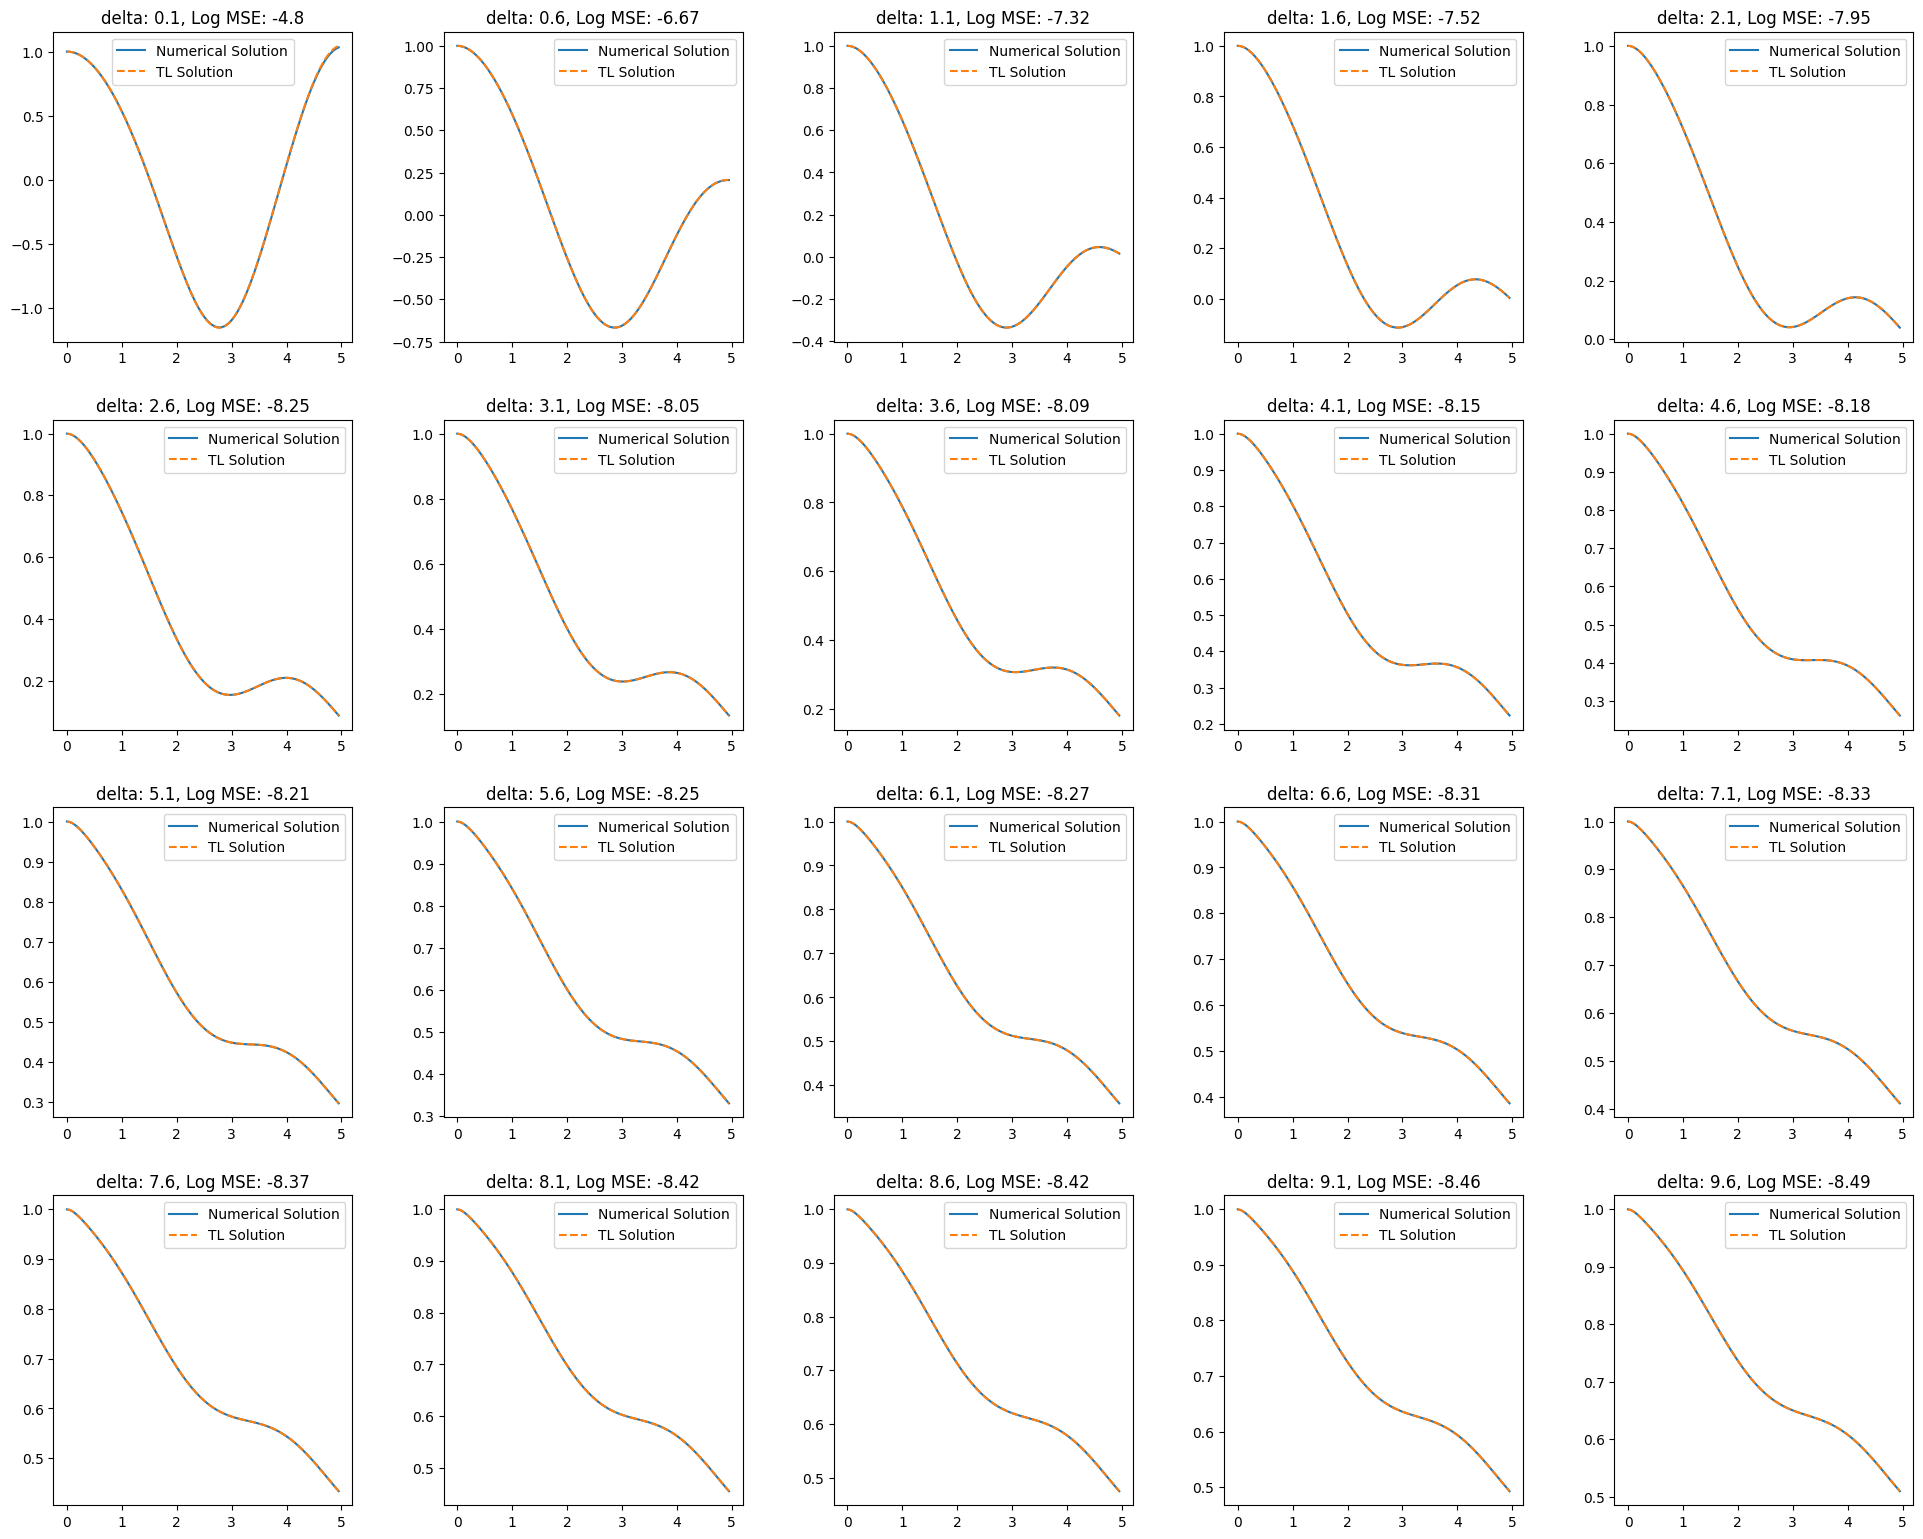

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(numerical_delta[i].t, numerical_delta[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_solutions_delta[i], '--', label="TL Solution")
  ax[j][k].legend()
  ax[j][k].set_title("delta: {}, Log MSE: {}".format(round(Delta[i], 1), round(np.log10(MSE_delta[i]), 2)))

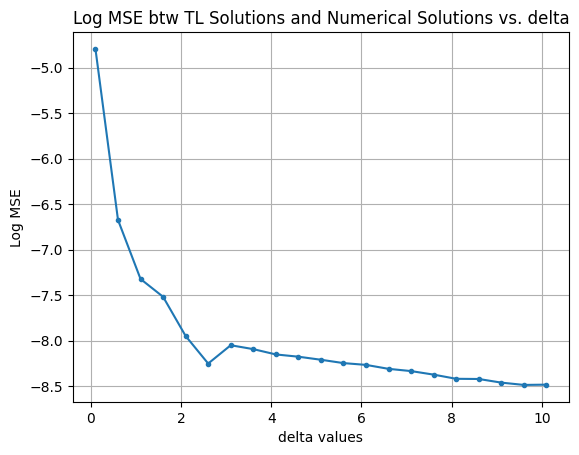

In [ ]:
plt.plot(Delta, np.log10(MSE_delta), '.-');
plt.grid();
plt.xlabel("delta values");
plt.ylabel("Log MSE");
plt.title("Log MSE btw TL Solutions and Numerical Solutions vs. delta");

### Out of Distribution Performance
We will try 20 out of distribution parameter sets. The first 10 parameter sets are in this range:

$$
\gamma \in (-2, 0.5); \omega \in (-2, 0.5); \alpha \in (-3.5, 0.5); \delta \in (-3.5, 0.5); x_0 \in (-9, -3)
$$

The last 10 parameter sets are in this range:

$$
\gamma \in (3, 5.5); \omega \in (3, 5.5); \alpha \in (4.5, 8.5); \delta \in (4.5, 8.5); x_0 \in (3, 9)
$$

In [ ]:
gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
alpha_bounds = (0.5, 4.5)
delta_bounds = (0.5, 4.5)
boundary_bounds = (-3, 3)

left_parameters = generate_parameters(10, gb = (-2, 0.5),
                        wb = (-2, 0.5), ab = (-3.5, 0.5), db = (-3.5, 0.5),
                        bounds=(-9, -3), seed=2)
right_parameters = generate_parameters(10, gb = (3, 5.5),
                        wb = (3, 5.5), ab = (4.5, 8.5), db = (4.5, 8.5),
                        bounds=(3, 9), seed=3)

out_parameters = (np.vstack((left_parameters[0], right_parameters[0])),
                  np.hstack((left_parameters[1], right_parameters[1])))

In [ ]:
##solve these 20 Duffing equations numerically and using TL
numerical_out = []
TL_functions_out = []
TL_solutions_out = []
for i in range(20):
  print(i)
  delta = out_parameters[0][i][3]
  alpha = out_parameters[0][i][2]
  bd = out_parameters[1][i]
  gamma = out_parameters[0][i][0]
  omega = out_parameters[0][i][1]
  #numerical solutions
  solu = solve_duffing(delta, alpha, 0.5,
                       lambda t: gamma*np.cos(omega*t),
                        [bd, 0], domain, X_grid)
  numerical_out.append(solu)
  #TL solutions
  p=12
  ff, _, _ = solve_duffing_TL(bd, 0.5, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_functions_out.append(ff)
  TL_solutions_out.append(ff(X_grid.flatten()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


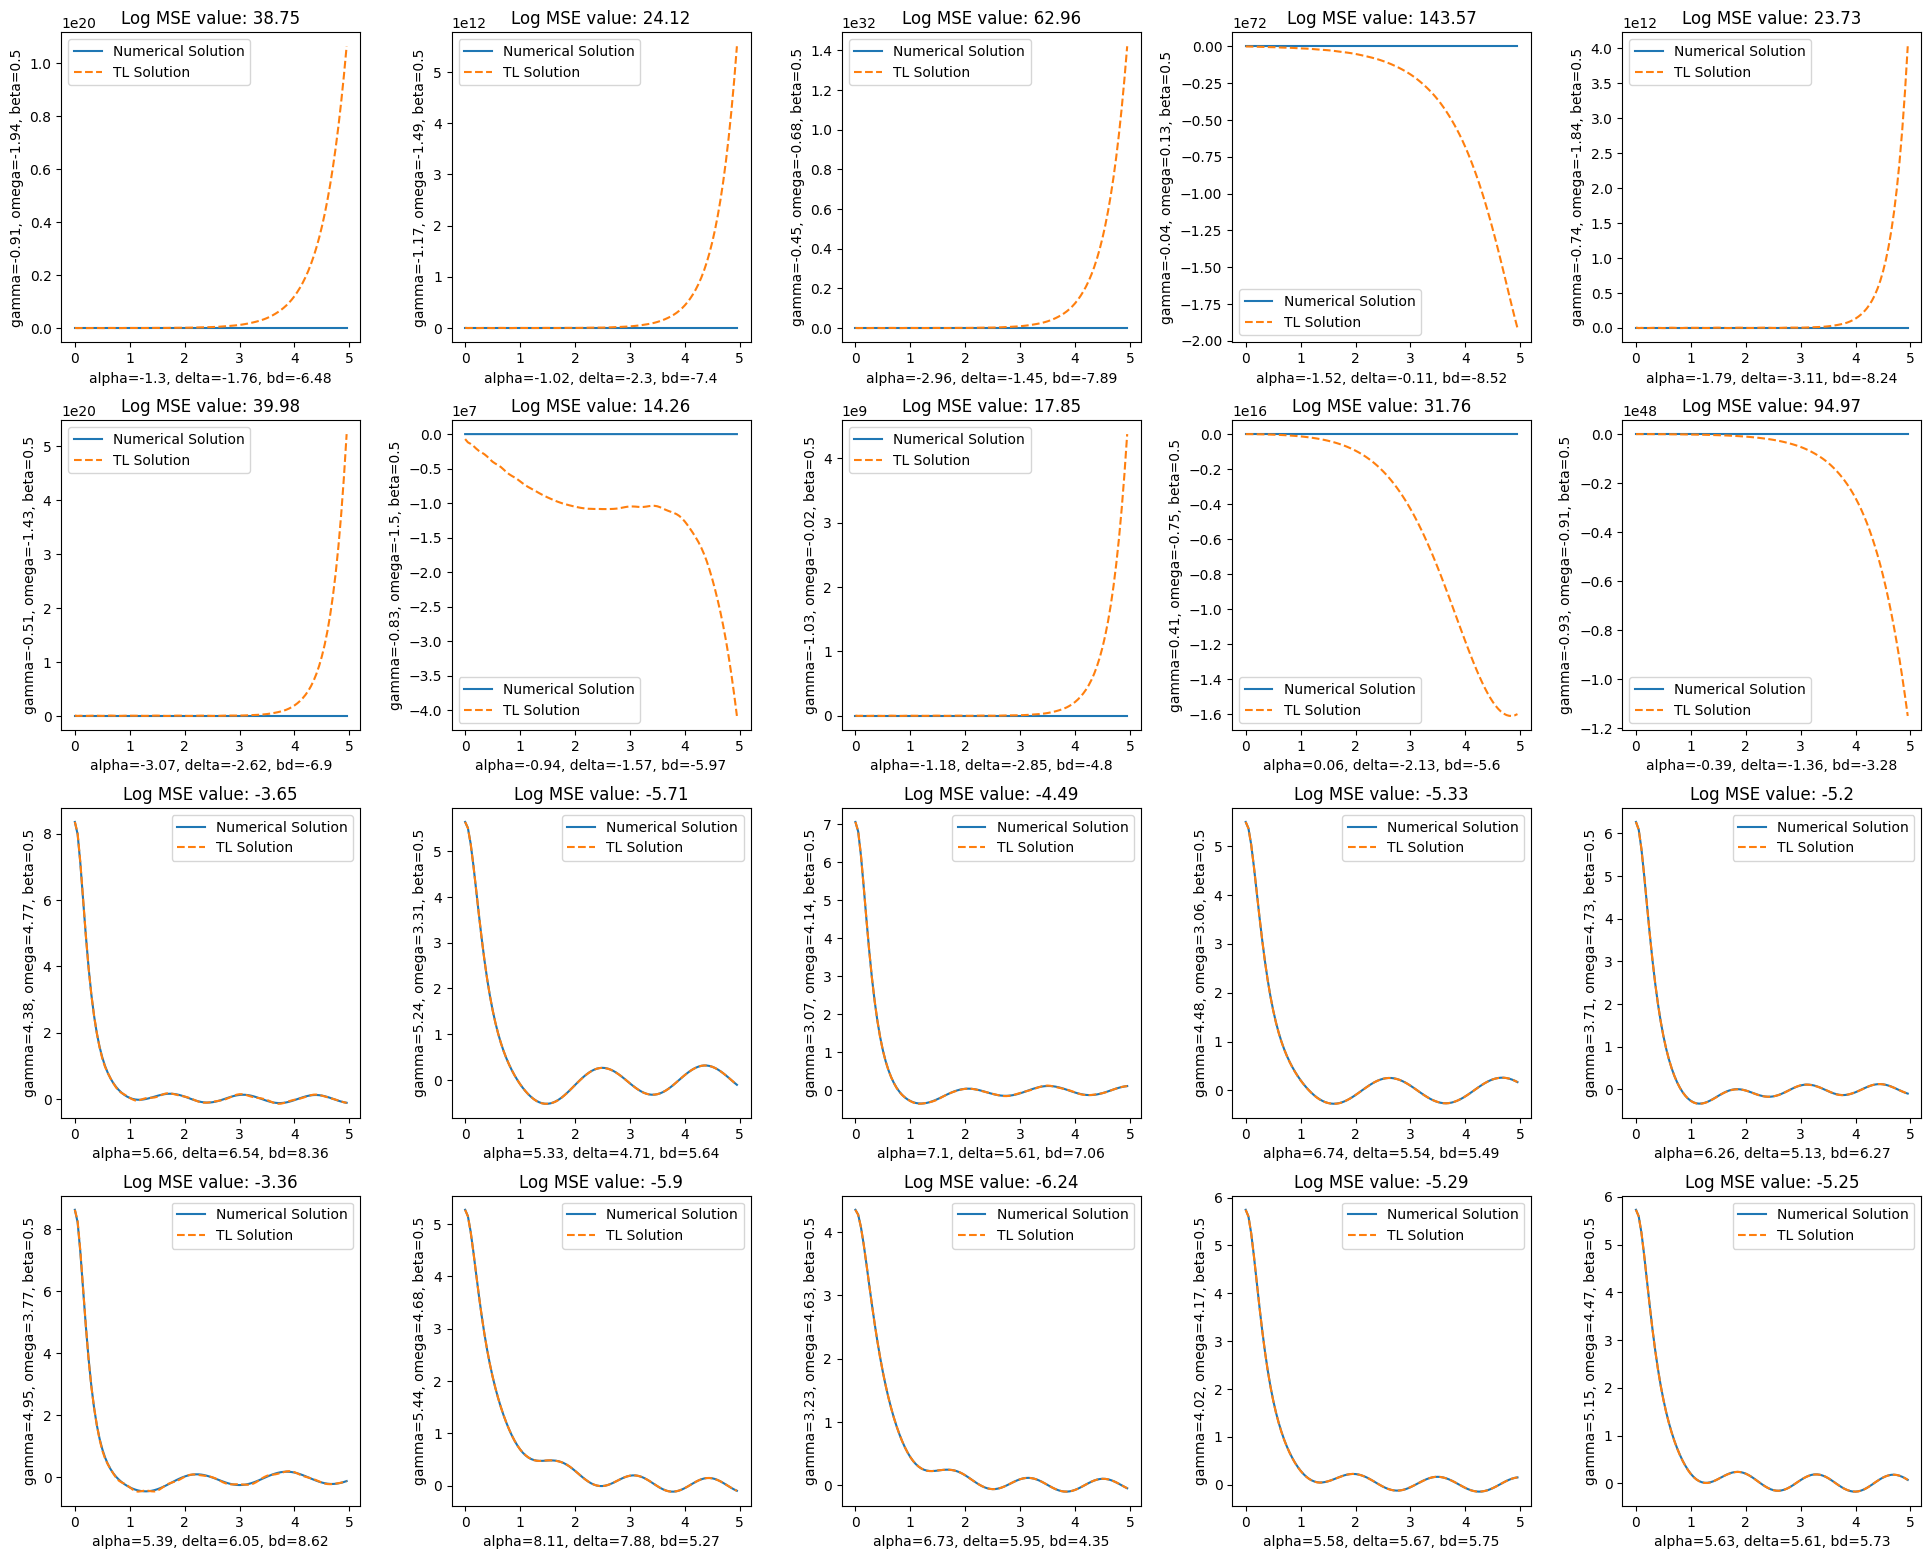

In [ ]:
##plot the solutions
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(numerical_out[i].t, numerical_out[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_solutions_out[i], '--', label='TL Solution')
  ##compute the MSE loss value
  loss = MSE_loss(TL_functions_out[i], numerical_out[i])
  ax[j][k].legend();
  ax[j][k].set_title("Log MSE value: " + str(round(np.log10(loss), 2)))
  ax[j][k].set_xlabel("alpha={}, delta={}, bd={}".format(round(out_parameters[0][i][2], 2),
                                                 round(out_parameters[0][i][3], 2),
                                                 round(out_parameters[1][i], 2)))
  ax[j][k].set_ylabel("gamma={}, omega={}, beta={}".format(
      round(out_parameters[0][i][0], 2),
      round(out_parameters[0][i][1], 2),
      0.5
  ))

The result shows that the perturbation method solver with TL solves the equation very well with the right out of distribution parameters (the second range shown before). But it fails to solve the equation with left out of distribution parameters (first range shown before).


Then the next step is to train the PINN using more diverse forcing functions.

First, we need to set out the set of forcing functions we want the network to learn. We consider trigonometric functions raised to higher orders.

Consider the following function format:

$$
f(t) = (a_1cos(w_1 t) + a_2cos(w_2t) + a_3cos(w_3t))^k
$$

For the first try, I will use 20 heads in the PINNs. with the following number of forcing functions:

1. 7 functions of format $\gamma cos(\omega t)$
2. 7 functions of format $(a_1cos(w_1t) + a_2cos(w_2t) + a_3cos(w_3t))^k$, k from 1 to 7
3. 6 functions of format $(a_1cos(w_1t) + a_2cos(w_2t) + a_3cos(w_3t))^{8}$

In [ ]:
##generate 20 random such functions
gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
np.random.seed(0)
function_list = []

def decorator1(r, w):
  def f(t):
    return r*np.cos(w*t)
  return f

def decorator2(a1, a2, a3, w1, w2, w3, k):
  def f(t):
    return (a1*np.cos(w1*t)+ a2*np.cos(w2*t) + a3*np.cos(w3*t))**k
  return f

a_list = []; w_list = []

for i in range(7):
  r = np.random.uniform(*gamma_bounds)
  w = np.random.uniform(*w_bounds)
  function_list.append(decorator1(r, w))
for i in range(7):
  [a1, a2, a3] = np.random.uniform(0.2, 0.6, 3)
  [w1, w2, w3] = np.random.uniform(1.5, 2.5, 3)
  a_list.append([a1, a2, a3]); w_list.append([w1, w2, w3])
  function_list.append(decorator2(a1, a2, a3, w1, w2, w3, i+1))
for i in range(6):
  [a1, a2, a3] = np.random.uniform(0.2, 0.6, 3)
  [w1, w2, w3] = np.random.uniform(1.5, 2.5, 3)
  a_list.append([a1, a2, a3])
  w_list.append([w1, w2, w3])
  function_list.append(decorator2(a1, a2, a3, w1, w2, w3, 8))

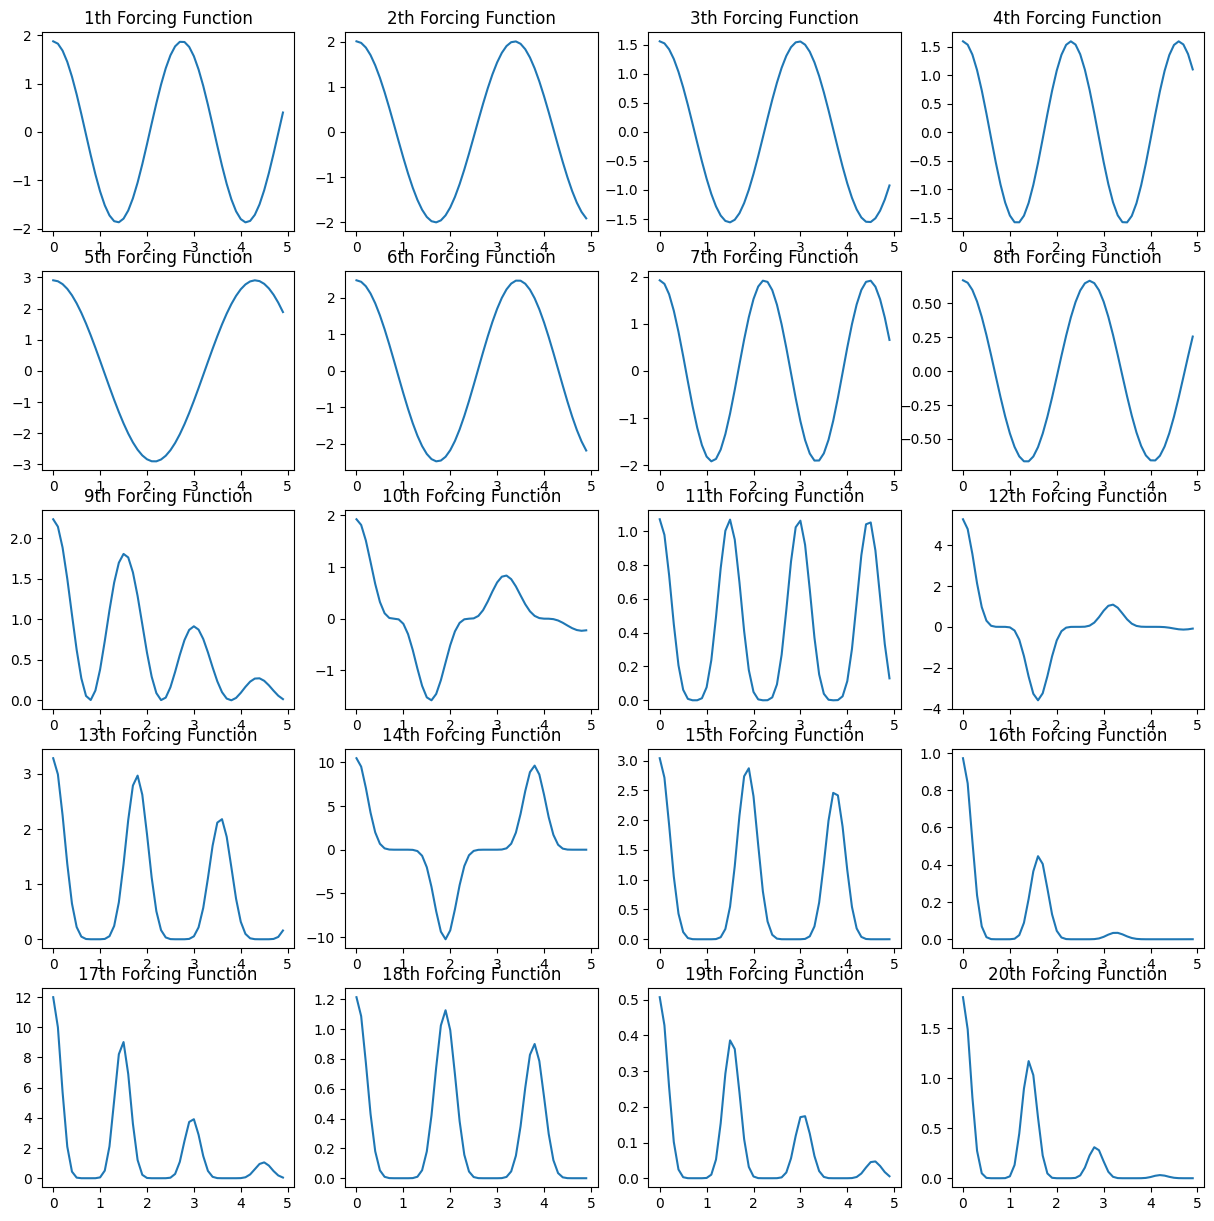

In [ ]:
##plot these forcing functions
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.1))
fig, ax = plt.subplots(5, 4, figsize=(15, 15))
for i in range(len(function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, function_list[i](X_grid));
  ax[j][k].set_title("{}th Forcing Function".format(i+1))

In [ ]:
##retrain the model using 20 heads
def Function_Decorator(f):
  def F(t):
    return torch.stack([torch.zeros_like(t), f(t)]).T
  return F
Function_list = [Function_Decorator(f) for f in function_list]

In [ ]:
##construct a model of 10 heads
k=20
model = Multihead(k=k)
fmodel, params = make_functional(model)

In [ ]:
parameter_set, F_BOUNDARIES = generate_parameters(k, seed=12)
A_matrices = torch.zeros(k, 2, 2)
for i in range(k):
  A_matrices[i] = torch.Tensor([[0.0, -1.0], [parameter_set[i][2], parameter_set[i][3]]])

In [ ]:
#define optimization configuration
batch_size = 100 ##number of colocation points sampled in each iteration
num_iter = 4000 #maximum number of iterations
learning_rate = 3e-4
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

In [ ]:
Alpha=1
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A_matrices, Function_list,
                                    optimizer, alpha=Alpha, display_every=100)

Iteration 99 with loss 0.9270027875900269, colocation: 0.7994101643562317, BC: 0.12759265303611755
Iteration 199 with loss 0.5767393112182617, colocation: 0.5724306702613831, BC: 0.004308611620217562
Iteration 299 with loss 0.3370104134082794, colocation: 0.3353816866874695, BC: 0.0016287307953462005
Iteration 399 with loss 0.19384917616844177, colocation: 0.19303776323795319, BC: 0.000811419275123626
Iteration 499 with loss 0.11839888989925385, colocation: 0.11807683110237122, BC: 0.00032205734169110656
Iteration 599 with loss 0.05549103766679764, colocation: 0.05533045530319214, BC: 0.00016058344044722617
Iteration 699 with loss 0.029684219509363174, colocation: 0.02955992892384529, BC: 0.00012429118214640766
Iteration 799 with loss 0.020975686609745026, colocation: 0.020896540954709053, BC: 7.914547313703224e-05
Iteration 899 with loss 0.014714055694639683, colocation: 0.014610589481890202, BC: 0.00010346648195991293
Iteration 999 with loss 0.011234750971198082, colocation: 0.011179

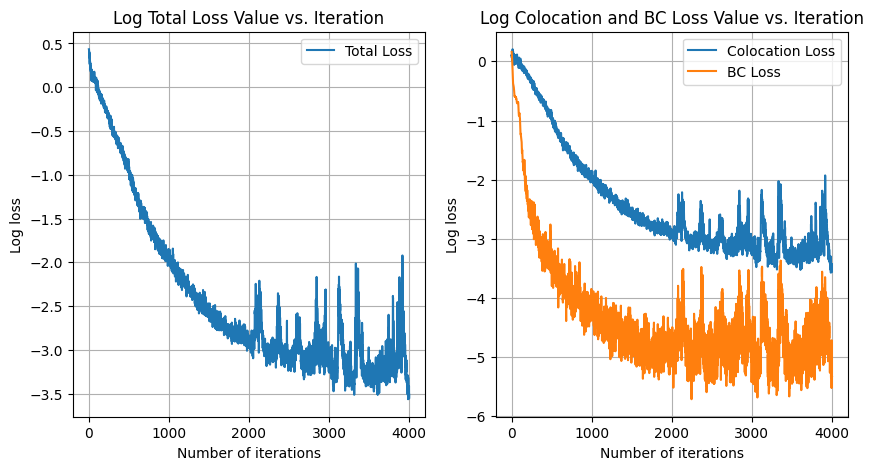

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f_multihead_vmap(X_grid, new_params) #shape (100, 20, 2)
Y_NN = Y_NN.transpose(0, 1)

In [ ]:
##get numerical solutions
#define the RHS function decorator
def RHS_decorator(f, alpha, delta):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + np.array([0, f(t)])
  return func

t_eval = np.arange(domain[0], domain[1], 0.05)
##construct a list of RHS functions
RHS_functions = [RHS_decorator(function_list[i], parameter_set[i][2], parameter_set[i][3]) for i in range(k)]

numerical_result = [solve_ivp(RHS_functions[i], domain,
                    np.array([F_BOUNDARIES[i], 0]), t_eval=t_eval) for i in range(k)]

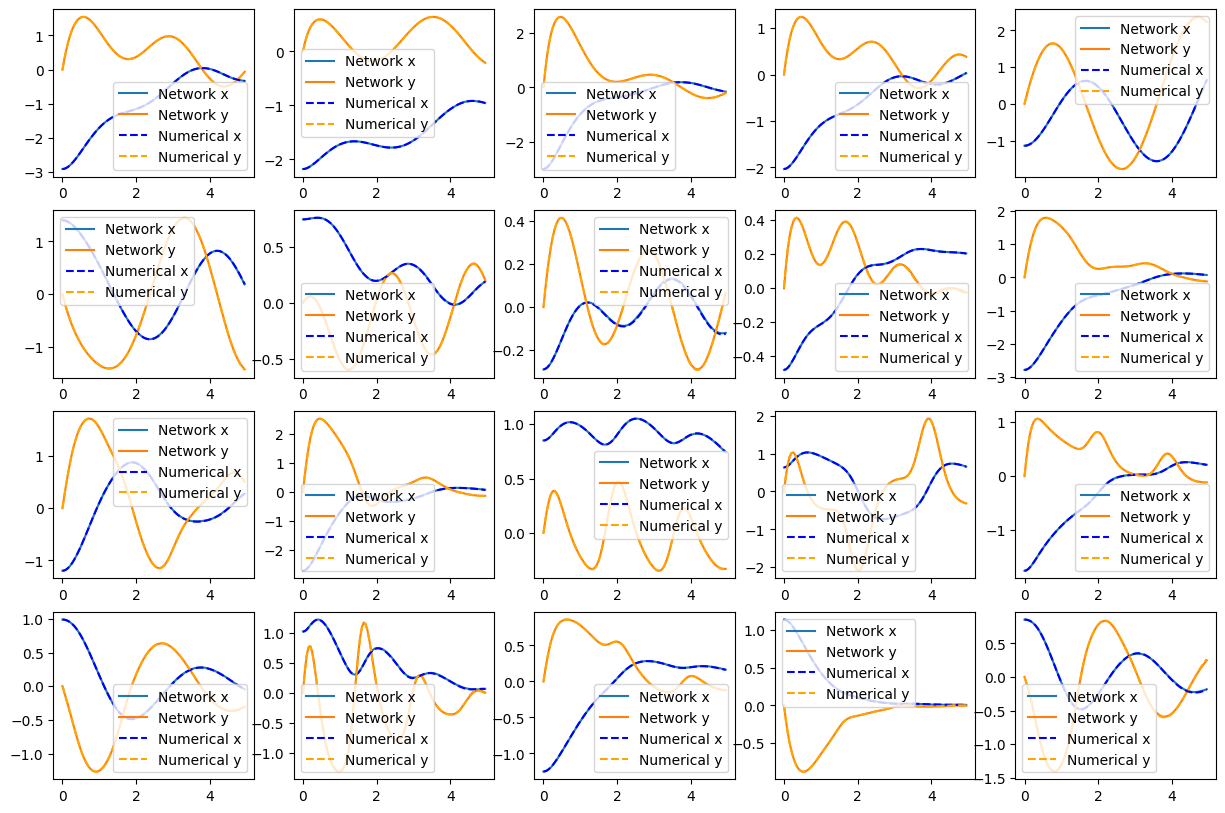

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(15, 10));
for i in range(k):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, Y_NN[i][:,0].detach().numpy(), label="Network x");
  ax[j][l].plot(X_grid, Y_NN[i][:,1].detach().numpy(), label='Network y');
  ax[j][l].plot(t_eval, numerical_result[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(t_eval, numerical_result[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].legend();

We can see that 20 head PINN is trained very well to almost solve the 20 system with complex forcing functions exactly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##save the parameters for future use
import pickle
file = open('/content/drive/MyDrive/PINN/PINN_program/new_params_20heads.obj', 'wb')
pickle.dump(new_params, file)
file.close()

In [ ]:
##reload the parameters if necessary
import pickle
file = open('/content/drive/MyDrive/PINN/PINN_program/new_params_20heads.obj', 'rb')
new_params = pickle.load(file)

Test the one-shot TL on the 20-head PINN to Solve Duffing Equation

In [ ]:
p = 15
final_function, function_list, W_list = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200,
                                  alpha, delta, new_params, gamma, omega)

Using uniform initial values of: 0.5000076295109483
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...
Solving the 5th linear ode system...
Solving the 6th linear ode system...
Solving the 7th linear ode system...
Solving the 8th linear ode system...
Solving the 9th linear ode system...
Solving the 10th linear ode system...
Solving the 11th linear ode system...
Solving the 12th linear ode system...
Solving the 13th linear ode system...
Solving the 14th linear ode system...
Solving the 15th linear ode system...


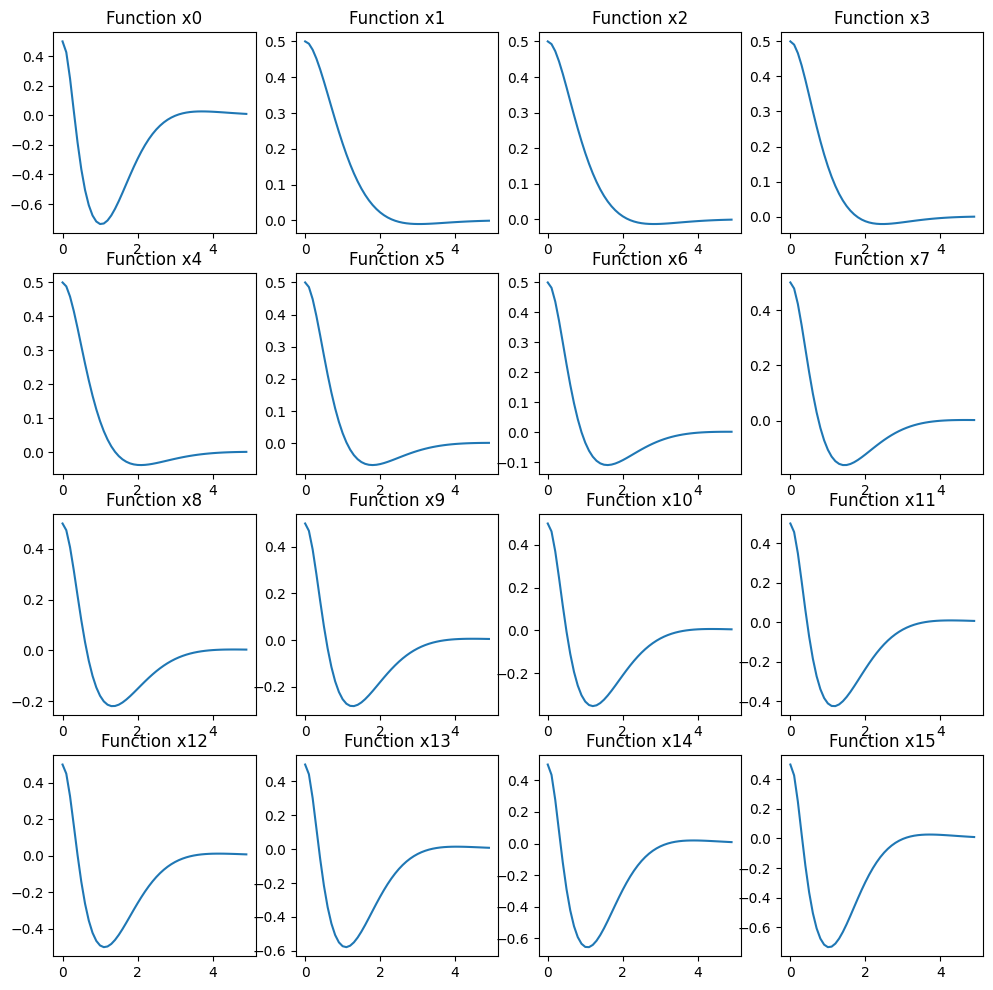

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(len(function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, function_list[i](X_grid))
  ax[j][k].set_title("Function x{}".format(i))

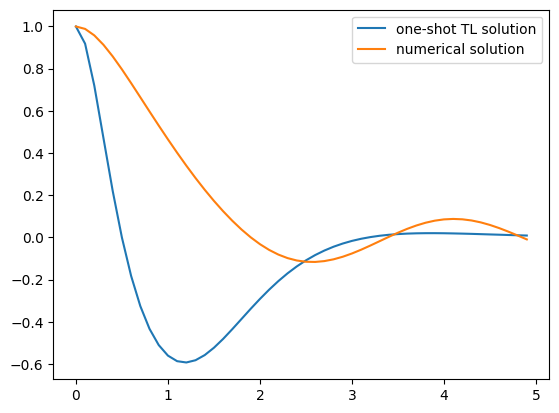

In [ ]:
plt.plot(X_grid, final_function(X_grid), label='one-shot TL solution');
plt.plot(solution.t, solution.y[0], label='numerical solution');
plt.legend();

We can see that using 20 heads and using more diverse and more complex forcing functions does not help.... Something else went wrong.